## Installed packages

In [1]:
#Import packages
import bisect
import datetime
import folium
import functools
import io
import logging
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, dates
import networkx as nx  
import numpy as np
import os
import pandas as pd
import pickle
import pyproj
import requests
import scipy as sc
import shapely.geometry
from shapely.geometry import Point,Polygon,MultiPolygon
from shapely.ops import transform
import shapely.wkt
import time as timpie
import xarray as xr
import scipy as sc
import yaml
import pytz

#Import packages OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel as vessel_
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
geod = pyproj.Geod(ellps="WGS84")
pd.set_option('display.max_rows', 500)

In [2]:
# fig,ax = plt.subplots()
# crossings_time = []
# crossings_limit = []
# for loc,info in crossing_dataframe_cvel.iterrows():
#     crossings_time.append(loc)
#     crossings_limit.append(info.Limit)
    
# plt.plot(current_velocity_data.TIME.values,abs(current_velocity_data.values))
# plt.plot(wlev_data.TIME.values,wlev_data.values)
# plt.plot(crossings_time,crossings_limit,'ko',markersize=4)
# for window in windows:
#     plt.fill([window[0],window[1],window[1],window[0]],[-1,-1,2,2],'lightgrey')
# plt.plot(cross_current_limit_dataframe.index.to_numpy(),cross_current_limit_dataframe.Limit.to_numpy(),'k--')
# plt.ylim(-1,2)
# plt.xlim(current_velocity_data.TIME.values[0],current_velocity_data.TIME.values[500]);

In [3]:
# current_velocity_data = hydrodynamic_data['Primary current velocity'][0].mean('LAYER')
# wlev_data = hydrodynamic_data['Astronomic water level'][0]
# tidal_period_data = hydrodynamic_data['Horizontal tidal periods'][0]
# tidal_periods = []
# for condition in tidal_period_data.values:
#     tidal_periods.append([np.datetime64(condition[0]),condition[1]])

In [4]:
# def create_horizontal_tidal_restriction(tidal_periods=[],method='critical current velocity'):
#     if method == 'point-based':
        
#     else:
#         flood_start_times = [time[0] for time in tidal_periods if time[1] == 'Flood Start']
#         ebb_start_times = [time[0] for time in tidal_periods if time[1] == 'Ebb Start']
#         cross_current_limit_dataframe = pd.DataFrame(columns=['Limit','Tide'])
#         for flood_start,ebb_start in zip(flood_start_times,ebb_start_times):
#             cross_current_limit_dataframe.at[flood_start-np.timedelta64(1,'ns'),'Limit'] = -1.0
#             cross_current_limit_dataframe.at[flood_start-np.timedelta64(1,'ns'),'Tide'] = 'Ebb'
#             cross_current_limit_dataframe.at[flood_start,'Limit'] = 1.0
#             cross_current_limit_dataframe.at[flood_start,'Tide'] = 'Flood'
#             cross_current_limit_dataframe.at[ebb_start-np.timedelta64(1,'ns'),'Limit'] = 1.0
#             cross_current_limit_dataframe.at[ebb_start-np.timedelta64(1,'ns'),'Tide'] = 'Flood'
#             cross_current_limit_dataframe.at[ebb_start,'Limit'] = -1.0
#             cross_current_limit_dataframe.at[ebb_start,'Tide'] = 'Ebb'
#         cross_current_limit_dataframe['Limit'] = cross_current_limit_dataframe.Limit.astype(float) 
#     return cross_current_limit_dataframe

## Some functions

In [5]:
@functools.lru_cache
def load_fis_network(url):
    """load the topological fairway information system network (vaarweginformatie.nl)"""

    # get the data from the url
    resp = requests.get(url)
    # convert to file object
    stream = io.StringIO(resp.text)
    
    # This will take a minute or two
    # Here we convert the network to a networkx object
    G = yaml.load(stream, Loader=yaml.Loader)

    # some brief info
    n_bytes = len(resp.content)
    msg = '''Loaded network from {url} file size {mb:.2f}MB. Network has {n_nodes} nodes and {n_edges} edges.'''
    summary = msg.format(url=url, mb=n_bytes / 1000**2, n_edges=len(G.edges), n_nodes=len(G.nodes))
    logger.info(summary)

    # The topological network contains information about the original geometry. 
    # Let's convert those into python shapely objects for easier use later
    for n in G.nodes:
        G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    for e in G.edges:
        edge = G.edges[e]
        edge['geometry'] = shapely.wkt.loads(edge['Wkt'])
        edge['length'] = edge_length(edge)    
    
    return G 

def edge_length(edge):
    """compute the great circle length of an edge
    The network version 0.1 contains the lat/lon distance in a length property. 
    But we need the "great circle" or projected distance. 
    Let's define a function to recompute it.
    """
    
    # get the geometry
    geom = edge['geometry']
    # get lon, lat
    lats, lons = np.array(geom).T
    # this requires pyproj 2.3.0
    distance = geod.line_length(lons, lats)

    return distance

def find_closest_edge(G, point):
    """find the closest edge on the graph from a given point"""
    
    distance = np.full((len(G.edges)), fill_value=np.nan)
    for ii, e in enumerate(G.edges):
        distance[ii] = point.distance(G.edges[e]['geometry'])
    name_edge = list(G.edges)[np.argmin(distance)]
    distance_edge = np.min(distance)
    
    return name_edge, distance_edge

def find_closest_node(G, point):
    """find the closest node on the graph from a given point"""
    
    distance = np.full((len(G.nodes)), fill_value=np.nan)
    for ii, n in enumerate(G.nodes):
        distance[ii] = point.distance(G.nodes[n]['geometry'])
    name_node = list(G.nodes)[np.argmin(distance)]
    distance_node = np.min(distance)
    
    return name_node, distance_node

def add_edge_to_network(FG,node1,node2):
    Info = {}
    Info['length'] = pyproj.Geod(ellps="WGS84").inv(FG.nodes[node1]['geometry'].x,
                                                    FG.nodes[node1]['geometry'].y,
                                                    FG.nodes[node2]['geometry'].x,
                                                    FG.nodes[node2]['geometry'].y,)[2]
    Info['geometry'] = shapely.geometry.LineString([FG.nodes[node1]['geometry'], FG.nodes[node2]['geometry']])
    geometry = Info['geometry']
    FG.add_edge(node1, node2, Info=Info, geometry=geometry)
    return

def calculate_distance(project,route):
    distance = 0
    for node1,node2 in zip(route[:-1],route[1:]):
        if 'length' in FG.edges[node1,node2,0]['Info']:
            distance += FG.edges[node1,node2,0]['Info']['length']
        else:
            line = FG.edges[node1,node2,0]['Info']['geometry']
            distance += transform(project, line).length
            
    return distance

def color_vessels(vessel,min_linewidth = 0.5,max_linewidth = 3,cmap = mpl.cm.get_cmap('Set1_r'),
                  draught_distribution = [4.6,5.6,8.7,10.25,11.7,12.4,13.95,15.0]):
    
    vessel_norm = mpl.colors.BoundaryNorm(boundaries=list(draught_distribution),ncolors=len(draught_distribution))
    vessel_cmap = cmap
    
    if str(type(vessel)) == "<class '__main__.Vessel'>":
        linewidth = vessel.T_f/(draught_distribution[-1]-draught_distribution[0])*max_linewidth+min_linewidth
        for c in enumerate(vessel_cmap.colors[1:(len(draught_distribution)+1)]):
            if vessel.T_f >= vessel_norm.boundaries[c[0]]:
                color = c[1]
            else:
                break
    else:
        color = []
        linewidth = []
        for draught in vessel:
            linewidth.append(draught/(draught_distribution[-1]-draught_distribution[0])*max_linewidth+min_linewidth)
        for c in enumerate(vessel_cmap.colors[1:(len(draught_distribution)+1)]):
            color.append(c[1])
        
    return color,linewidth

def vessel_legend(axis,start_time,min_linewidth = 0.5,max_linewidth = 3,cmap = mpl.colorbar.cm.tab10,
                  vessel_types=['Small Coaster 1','Small Coaster 2','Coaster','Handysize','Medium Range','Long Range 1','Long Range 2 I','Long Range 2 II'],
                  draught_distribution = [4.6,5.6,8.7,10.25,11.7,12.4,13.95,15.0]):               

    vessel_norm = mpl.colors.BoundaryNorm(boundaries=list(draught_distribution),ncolors=len(draught_distribution))
    vessel_cmap = cmap
    
    ylim = axis.axes.get_xlim()
    colors,linestyles = color_vessels(draught_distribution)
    for vtype in enumerate(vessel_types):
        axis.plot([-1000,-1000],[start_time-1000,start_time-1000],
                  color=colors[vtype[0]],
                  label=str(vtype[1]))
    leg= axis.legend(loc='lower right',handlelength=8,ncol=2,bbox_to_anchor=(0.95, -0.25),frameon=False)
    for line in leg.get_lines():
        line.set_linewidth((max_linewidth-min_linewidth)*0.5+min_linewidth)
        
    axis.plot([-1000,-1000],[start_time-1000,start_time-1000],
             color='k',
             linewidth = draught_distribution[0]/(draught_distribution[-1]-draught_distribution[0])*max_linewidth+min_linewidth,
             label=str(round(draught_distribution[0],2)) +' m')
                                                  
    for vtype in enumerate(vessel_types):
        axis.plot([-1000,-1000],[start_time-1000,start_time-1000],
                 color='k',
                 linewidth = draught_distribution[vtype[0]]/(draught_distribution[-1]-draught_distribution[0])*max_linewidth+min_linewidth,
                 label=str(round(draught_distribution[vtype[0]],2)) +' m')
    plt.legend(loc='lower right',handlelength=9,ncol=3,bbox_to_anchor=(1.35, -0.215),frameon=False)

def tidal_window_visualization(origin,FG,start_time,end_time,start_node,end_node,T_lower_limit,T_upper_limit,T_ticks,bound):
    T_list = np.arange(T_lower_limit,T_upper_limit,T_ticks)
    route = nx.dijkstra_path(FG, start_node, end_node)
    vessels = []
    for draught in T_list:
        vessels.append(Vessel(FG=FG,
                              start_time = simulation_start.timestamp(),
                              name = 'Tanker',
                              T = draught,
                              L = 149,
                              v = 4.5,
                              B = 27,
                              ukc = 0,
                              mccur = 0,
                              mwt = end_time-start_time,
                              bound = bound,
                              typ = 'Handysize',
                              network = FG,
                              start_node = start_node,
                              end_node = end_node,
                              sailing_time_to_terminal=0))
        
    sail_in_times_tidal_window = []
    for vessel in vessels:
        sail_in_times_tidal_window.append(env.vessel_traffic_service.provide_sail_in_times_tidal_window(vessel,vessel.route))

    corrected_sail_in_times_tidal_window = []
    for sail_in_times_tidal_windows_vessel in sail_in_times_tidal_window:
        corrected_sail_in_times_tidal_window_vessel = []
        if sail_in_times_tidal_windows_vessel[0] != []:
            if sail_in_times_tidal_windows_vessel[0][1] == 'Stop':
                corrected_sail_in_times_tidal_window.append([[sail_in_times_tidal_windows_vessel[0][t[0]-1][0],t[1][0]] for t in enumerate(sail_in_times_tidal_windows_vessel[0]) if t[1][1] == 'Start'])
            else:
                corrected_sail_in_times_tidal_window.append([[t[1][0],sail_in_times_tidal_windows_vessel[0][t[0]+1][0]] for t in enumerate(sail_in_times_tidal_windows_vessel[0]) if t[1][1] == 'Stop' and t[0] != len(sail_in_times_tidal_windows_vessel[0])-1])
        else:
            corrected_sail_in_times_tidal_window.append([[start_time,end_time],
                                                         [start_time,end_time]])                              
    
    indexes = []
    timestamp = []
    for corrected_sail_in_times in corrected_sail_in_times_tidal_window:
        for times in corrected_sail_in_times:
            timestamp.extend([times[0],times[1]])
    timestamp.sort()
    timestamp = list(dict.fromkeys(timestamp))

    timestamps = []
    timestamps.append(start_time)
    for time_index,time in enumerate(timestamp):
        if time_index != 0 and time_index != len(timestamp)-1:
            timestamps.extend([time,time])
        else:
            timestamps.append(time)
    timestamps.append(end_time)
    
    values = np.zeros(len(timestamps))    
    for vessel_index,corrected_sail_in_times_tidal_window_vessel in enumerate(corrected_sail_in_times_tidal_window):
        for time_index,time_tidal_window in enumerate(corrected_sail_in_times_tidal_window_vessel):
            if time_tidal_window[1] <= end_time:
                indx1 = timestamps.index(time_tidal_window[0])
                indx2 = timestamps.index(time_tidal_window[1])
                if indx2 != len(timestamps)-1 and time_tidal_window[1] != end_time:
                    if indx1 != 0:
                        indx1 = indx1+1
                    for indx,_ in enumerate(timestamps[indx1:indx2+1]):
                        values[indx+indx1] = vessels[vessel_index].T_f
                else:
                    if indx1 != 0:
                        indx1 = indx1+1
                        for indx,_ in enumerate(timestamps[indx1:]):
                            values[indx+indx1] = vessels[vessel_index].T_f
                    else:
                        for indx,_ in enumerate(timestamps):
                            values[indx] = vessels[vessel_index].T_f
                        break
            elif time_tidal_window[0] <= end_time:
                indx1 = timestamps.index(time_tidal_window[0])+1
                for indx,_ in enumerate(timestamps[indx1:]):
                    values[indx+indx1] = vessels[vessel_index].T_f

    distance = calculate_distance(project,nx.dijkstra_path(FG,origin,end_node))

    locations = list(distance*np.ones(len(timestamps)))
    indexes = nx.dijkstra_path(FG,origin,end_node).index(start_node)*np.ones(len(timestamps))

    return indexes,locations,timestamps,values

def create_tidal_window_tiles(FG,origin,start_time,end_time,start_node,end_node,bound):
    I = []
    X = []
    Y = []
    Z = []
    route = nx.dijkstra_path(FG,start_node,end_node)
    T_lower_limit = 4.5
    T_ticks = 0.05
    T_upper_limit = 16+T_ticks
    for node in enumerate(route):
        i,x,y,z = tidal_window_visualization(origin,FG,start_time,end_time,node[1],node[1],T_lower_limit,T_upper_limit,T_ticks,bound)
        I.append(i)
        X.append(x)
        Y.append(y)
        Z.append(z)
    
    x_int = []
    y_int = []
    z_int = []
    
    for x in enumerate(X):  
        intrp = sc.interpolate.interp1d(Y[x[0]],Z[x[0]])
        y_intrp = np.linspace(start_time,end_time,1000)
        x_intrp = x[1][0]*np.ones(1000)
        z_intrp = intrp(y_intrp)
        x_int.append(x_intrp)
        y_int.append(y_intrp)
        z_int.append(z_intrp)
    
    return x_int,y_int,z_int

def plot_tidal_window_tiles(axis,x_int,y_int,z_int,norm,cmap):
    if len(y_int) > 3:
        for y in enumerate(y_int[0]):
            x_intrp_old = [x[y[0]] for x in x_int]
            z_intrp_old = [z[y[0]] for z in z_int]
            intrp = sc.interpolate.interp1d(x_intrp_old,z_intrp_old,fill_value='extrapolate')
            x_intrp = np.linspace(0,axis.axes.get_xlim()[1],1000)
            y_intrp = y[1]*np.ones(1000)
            z_intrp = intrp(x_intrp)
            axis.scatter(x_intrp,y_intrp,s=2,c=z_intrp,norm=norm,cmap=cmap)
        
    else:
        for y in enumerate(y_int[0]):
            x_intrp_old = [[x for x in x_int][0][y[0]]-100,[x for x in x_int][0][y[0]]+100]
            z_intrp_old = [[z for z in z_int][0][y[0]],[z for z in z_int][0][y[0]]]
            intrp = sc.interpolate.interp1d(x_intrp_old,z_intrp_old,fill_value='extrapolate')
            x_intrp = np.linspace(-100+horizontal_tidal_restriction_distance,100+horizontal_tidal_restriction_distance,1000)
            y_intrp = y[1]*np.ones(1000)
            z_intrp = intrp(x_intrp)
            axis.scatter(x_intrp,y_intrp,s=2,c=z_intrp,norm=norm,cmap=cmap)  
    return

## Simulation settings

In [6]:
simulation_start = datetime.datetime(2019,1,1,0,0,0).replace(tzinfo=pytz.utc)
simulation_stop = datetime.datetime(2020,1,1,0,0,0).replace(tzinfo=pytz.utc)

## Import FIS network

In [7]:
url = 'https://zenodo.org/record/4578289/files/network_digital_twin_v0.2.yaml'

# create a cached version to speed up loading (remove cached file if a better yaml file is available)
fname = "fis_cache\\{}.pkl".format('FIS')

if os.path.exists(fname):
    print('I am loading cached network')
    with open(fname, 'rb') as pkl_file:
        FG = pickle.load(pkl_file)
        pkl_file.close()

else:
    print('I am getting new network')
    FG = load_fis_network(url)

    os.makedirs(os.path.dirname(fname), exist_ok=True)
    with open(fname, 'wb') as pkl_file:
        pickle.dump(FG, pkl_file)
        pkl_file.close()

I am loading cached network


C:\Users\floorbakker\AppData\Local\Temp\ipykernel_6236\3682999432.py:9: UserWarning:

Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.



## Selection area of the Port of Rotterdam

In [8]:
polygon = shapely.geometry.Polygon([[4.047046106288641, 51.994530949601149, 0.0 ], [ 4.041820334307678, 51.985794447379547, 0.0 ], [ 4.032638009410599, 51.987359301430168, 0.0 ], [ 4.026085029365865, 51.986529814588927, 0.0 ], [ 4.023082985071111, 51.985502004661448, 0.0 ], [ 4.00823290473104, 51.988174970713708, 0.0 ], [ 3.998553814899393, 51.987323088053131, 0.0 ], [ 3.987086024543889, 51.983489630873457, 0.0 ], [ 3.980367408521741, 51.978923864007278, 0.0 ], [ 3.972858821044363, 51.972254400764548, 0.0 ], [ 3.964975414140348, 51.962100235646908, 0.0 ], [ 3.965767078274776, 51.958192943818972, 0.0 ], [ 3.9714783688349, 51.946631494630573, 0.0 ], [ 3.983298387670107, 51.927838319363971, 0.0 ], [ 3.987657598176972, 51.919192330532567, 0.0 ], [ 3.996387468717351, 51.916655170259958, 0.0 ], [ 4.001520162387755, 51.917060309257401, 0.0 ], [ 4.012557173047844, 51.920229693122977, 0.0 ], [ 4.048001660981074, 51.929016004063037, 0.0 ], [ 4.074660383723856, 51.934902766449348, 0.0 ], [ 4.093265372959262, 51.934893193914142, 0.0 ], [ 4.109255167927888, 51.93372388247014, 0.0 ], [ 4.126734837924461, 51.932516710383318, 0.0 ], [ 4.139980260895813, 51.931607190411903, 0.0 ], [ 4.147852124552989, 51.929605717664337, 0.0 ], [ 4.154871093926527, 51.92643205114458, 0.0 ], [ 4.164068865894088, 51.922235472642527, 0.0 ], [ 4.168497166059588, 51.919961894548123, 0.0 ], [ 4.173765785457206, 51.917888566713337, 0.0 ], [ 4.177471853896762, 51.916075611730989, 0.0 ], [ 4.19143525340012, 51.910078064370317, 0.0 ], [ 4.202511571167557, 51.904617634287582, 0.0 ], [ 4.212615864448434, 51.899592844692521, 0.0 ], [ 4.219017538516361, 51.895881651452001, 0.0 ], [ 4.223832400198837, 51.890530353414427, 0.0 ], [ 4.226873738466466, 51.887326711590937, 0.0 ], [ 4.228951660169189, 51.883411780650917, 0.0 ], [ 4.230693981376918, 51.879498998972053, 0.0 ], [ 4.23245567320008, 51.876804618361149, 0.0 ], [ 4.235713735314597, 51.874394644882933, 0.0 ], [ 4.240860704028409, 51.871936856471507, 0.0 ], [ 4.246713039932697, 51.869742419056138, 0.0 ], [ 4.256500276768536, 51.866468683159347, 0.0 ], [ 4.263681165876234, 51.864338061762467, 0.0 ], [ 4.270856008579235, 51.864165082808469, 0.0 ], [ 4.277892120705451, 51.86439728390355, 0.0 ], [ 4.286849974208358, 51.8645882221536, 0.0 ], [ 4.292522161762808, 51.864277013800361, 0.0 ], [ 4.299811679854974, 51.864101583593218, 0.0 ], [ 4.311303788739909, 51.864116069612663, 0.0 ], [ 4.329734623050854, 51.864276123508454, 0.0 ], [ 4.331499517754396, 51.864024053521959, 0.0 ], [ 4.333688920564924, 51.862880975070347, 0.0 ], [ 4.336262605418339, 51.859939034098609, 0.0 ], [ 4.34137585560622, 51.854360268676722, 0.0 ], [ 4.351538393640837, 51.847648283939193, 0.0 ], [ 4.362976373927347, 51.843831785091027, 0.0 ], [ 4.370084445558557, 51.841582728647857, 0.0 ], [ 4.380089933091171, 51.840617401653859, 0.0 ], [ 4.391081067036453, 51.839898516477582, 0.0 ], [ 4.399478875843261, 51.840163345822617, 0.0 ], [ 4.408773767123155, 51.841091522022268, 0.0 ], [ 4.416943663050734, 51.840074266710687, 0.0 ], [ 4.423210503951149, 51.838579340029192, 0.0 ], [ 4.427503697165283, 51.836513860483983, 0.0 ], [ 4.425576770167599, 51.834095807664362, 0.0 ], [ 4.429533318178938, 51.832633476567118, 0.0 ], [ 4.430960005176178, 51.833741029897993, 0.0 ], [ 4.434887510360975, 51.833765267256481, 0.0 ], [ 4.43690383938546, 51.83312364379659, 0.0 ], [ 4.444075259200149, 51.831057027288622, 0.0 ], [ 4.455433085635423, 51.829280289923247, 0.0 ], [ 4.46771578321205, 51.829690776121659, 0.0 ], [ 4.478878685926199, 51.830795076878637, 0.0 ], [ 4.488164498900886, 51.832451656061437, 0.0 ], [ 4.497474736200315, 51.832277533876983, 0.0 ], [ 4.504006118328753, 51.831563991137351, 0.0 ], [ 4.512048063063212, 51.829681547431278, 0.0 ], [ 4.52023617846478, 51.827734951843553, 0.0 ], [ 4.527396173112097, 51.827099310549393, 0.0 ], [ 4.533930342872021, 51.828087046218492, 0.0 ], [ 4.54119648874229, 51.829604882537978, 0.0 ], [ 4.546648500960357, 51.829305402579081, 0.0 ], [ 4.552248982461713, 51.827676804936857, 0.0 ], [ 4.554747912727908, 51.824662856298893, 0.0 ], [ 4.557658515089615, 51.818037740135757, 0.0 ], [ 4.562338329955282, 51.812146737080482, 0.0 ], [ 4.567790268643788, 51.808872879868893, 0.0 ], [ 4.575257216434827, 51.80678730057928, 0.0 ], [ 4.58251573514719, 51.805521253772739, 0.0 ], [ 4.590037627731165, 51.805171699165371, 0.0 ], [ 4.597774284387466, 51.804055987532443, 0.0 ], [ 4.604313450900881, 51.802297307784549, 0.0 ], [ 4.613475866941057, 51.800235897440317, 0.0 ], [ 4.617341098435928, 51.798124369718323, 0.0 ], [ 4.618362378336296, 51.796181342994132, 0.0 ], [ 4.621252023873148, 51.790276378816401, 0.0 ], [ 4.62409979956345, 51.782635434416783, 0.0 ], [ 4.623941953031045, 51.77630929086952, 0.0 ], [ 4.623064754206448, 51.763389962802563, 0.0 ], [ 4.624433481891639, 51.757517082463593, 0.0 ], [ 4.627814435262847, 51.75075427110778, 0.0 ], [ 4.627879472881458, 51.743955186361127, 0.0 ], [ 4.626354092832785, 51.736179071181077, 0.0 ], [ 4.623290219595805, 51.726941768179799, 0.0 ], [ 4.619409050652274, 51.721750961942199, 0.0 ], [ 4.616120550381302, 51.716182645862659, 0.0 ], [ 4.609566079180749, 51.709477107202552, 0.0 ], [ 4.605050592100282, 51.705466495857721, 0.0 ], [ 4.600730591394282, 51.702608721228763, 0.0 ], [ 4.593484968687383, 51.700694538430596, 0.0 ], [ 4.578029217511245, 51.698311310158317, 0.0 ], [ 4.566507458151197, 51.695868601503108, 0.0 ], [ 4.556646021680121, 51.694506492441057, 0.0 ], [ 4.544885547002719, 51.692528879578767, 0.0 ], [ 4.546338018922178, 51.687750048814117, 0.0 ], [ 4.567420841100791, 51.69114986797571, 0.0 ], [ 4.568815806261195, 51.688246505711163, 0.0 ], [ 4.574402919128991, 51.673642115923442, 0.0 ], [ 4.582440212968, 51.675045873653353, 0.0 ], [ 4.603759922942611, 51.67909424032014, 0.0 ], [ 4.609000212678733, 51.682787850019203, 0.0 ], [ 4.61322770400086, 51.687589032555543, 0.0 ], [ 4.616346068304478, 51.688505385639402, 0.0 ], [ 4.618177114470288, 51.689083597445311, 0.0 ], [ 4.611503886862787, 51.700539553693048, 0.0 ], [ 4.618547235224733, 51.704758620916408, 0.0 ], [ 4.621188579458506, 51.70912483940171, 0.0 ], [ 4.625278654281832, 51.71853614447808, 0.0 ], [ 4.62895981688983, 51.726591934181187, 0.0 ], [ 4.631015273970891, 51.731345868647637, 0.0 ], [ 4.632270606035429, 51.73633287458577, 0.0 ], [ 4.634070893980669, 51.74383147071385, 0.0 ], [ 4.633874592083471, 51.752192752634713, 0.0 ], [ 4.630948981882912, 51.759574802772647, 0.0 ], [ 4.629120910421564, 51.765486142676011, 0.0 ], [ 4.629532349597874, 51.770814439938789, 0.0 ], [ 4.630894904718586, 51.77947979515762, 0.0 ], [ 4.630205119517427, 51.784593728340461, 0.0 ], [ 4.644155121160485, 51.784738066131723, 0.0 ], [ 4.64675789658717, 51.785521955122, 0.0 ], [ 4.648523080480585, 51.787655536083861, 0.0 ], [ 4.648380883747016, 51.791059131401887, 0.0 ], [ 4.648653816976214, 51.797693391205897, 0.0 ], [ 4.64901104999494, 51.806929426135078, 0.0 ], [ 4.649005053746082, 51.807578765213528, 0.0 ], [ 4.644316669744375, 51.808880483719882, 0.0 ], [ 4.641063113733887, 51.807100885321567, 0.0 ], [ 4.636305758391581, 51.805050274482483, 0.0 ], [ 4.631933508015191, 51.803574293533259, 0.0 ], [ 4.626968120311867, 51.802438675475052, 0.0 ], [ 4.620497311172034, 51.802272999154503, 0.0 ], [ 4.615951679076103, 51.803311401541073, 0.0 ], [ 4.606272307986039, 51.806284851480697, 0.0 ], [ 4.596159971591947, 51.808126778121583, 0.0 ], [ 4.586158031535925, 51.808844780132617, 0.0 ], [ 4.579447886128047, 51.810058867002901, 0.0 ], [ 4.573060189604023, 51.812295490473929, 0.0 ], [ 4.566012519971096, 51.815434547502242, 0.0 ], [ 4.563773566221736, 51.818687634757516, 0.0 ], [ 4.563201599006845, 51.821957279842117, 0.0 ], [ 4.562968089313304, 51.824543181240337, 0.0 ], [ 4.558540613429947, 51.82964006740454, 0.0 ], [ 4.552433393126092, 51.832316314254932, 0.0 ], [ 4.545014088655261, 51.834290234059893, 0.0 ], [ 4.537158070334188, 51.833393779336141, 0.0 ], [ 4.530038207031499, 51.832102384556208, 0.0 ], [ 4.526108059542169, 51.831813208714102, 0.0 ], [ 4.521717619046028, 51.832590425155978, 0.0 ], [ 4.516732521897168, 51.833960245101871, 0.0 ], [ 4.514236527391809, 51.834496902354807, 0.0 ], [ 4.509974165494395, 51.83553112330867, 0.0 ], [ 4.501820011750192, 51.837106988151767, 0.0 ], [ 4.495840125581275, 51.837258622122228, 0.0 ], [ 4.486864901019976, 51.837137748460393, 0.0 ], [ 4.478183135596048, 51.83618389210767, 0.0 ], [ 4.472439264345458, 51.835228495563783, 0.0 ], [ 4.461775016379061, 51.833908716258769, 0.0 ], [ 4.453922237117189, 51.833744056940958, 0.0 ], [ 4.445880993540623, 51.83521472745835, 0.0 ], [ 4.433867160146994, 51.838656519273393, 0.0 ], [ 4.42470273645797, 51.841440135427547, 0.0 ], [ 4.42153152386223, 51.842243381585881, 0.0 ], [ 4.412288631756962, 51.844837057595839, 0.0 ], [ 4.404628276058093, 51.845147332925059, 0.0 ], [ 4.394141940257916, 51.844056513242528, 0.0 ], [ 4.385970084449699, 51.84384058231597, 0.0 ], [ 4.38009310776012, 51.844281463545563, 0.0 ], [ 4.36989301637785, 51.845910018863457, 0.0 ], [ 4.360483758821787, 51.848313888858193, 0.0 ], [ 4.354349626537848, 51.851008172324264, 0.0 ], [ 4.347909504952052, 51.855404628831913, 0.0 ], [ 4.342408539850937, 51.86054970135617, 0.0 ], [ 4.337899232746361, 51.865294765331257, 0.0 ], [ 4.335433216951134, 51.869785988478348, 0.0 ], [ 4.333552618008243, 51.873809653870651, 0.0 ], [ 4.348428925913814, 51.875946272051308, 0.0 ], [ 4.369163929813908, 51.878317553006468, 0.0 ], [ 4.38839016518595, 51.87815521453539, 0.0 ], [ 4.401107220355129, 51.877058298559803, 0.0 ], [ 4.426040664379522, 51.873026806667077, 0.0 ], [ 4.437079597260853, 51.871386012190683, 0.0 ], [ 4.448943520990141, 51.871564030747429, 0.0 ], [ 4.454263046403941, 51.871932213390657, 0.0 ], [ 4.454612554075805, 51.876499560242912, 0.0 ], [ 4.461854063353627, 51.892501464714812, 0.0 ], [ 4.466785298039618, 51.894872117693943, 0.0 ], [ 4.472093734132137, 51.894358029456889, 0.0 ], [ 4.475597745139166, 51.893088291767661, 0.0 ], [ 4.495575011014354, 51.897022475135103, 0.0 ], [ 4.497482873128506, 51.904708775055248, 0.0 ], [ 4.483610341771596, 51.910345930077462, 0.0 ], [ 4.482760758326021, 51.909513132342788, 0.0 ], [ 4.481354888673367, 51.907659452044847, 0.0 ], [ 4.480171615622785, 51.906587418413928, 0.0 ], [ 4.478656007166948, 51.905614334220239, 0.0 ], [ 4.47420728963661, 51.903986716234108, 0.0 ], [ 4.468091888502901, 51.902252150225287, 0.0 ], [ 4.465003985162294, 51.907646878763657, 0.0 ], [ 4.462309529254382, 51.906989997256652, 0.0 ], [ 4.458607445683542, 51.904702185072551, 0.0 ], [ 4.450510265256744, 51.902876957622773, 0.0 ], [ 4.444600706587229, 51.903309513507153, 0.0 ], [ 4.440641527550353, 51.905721770934349, 0.0 ], [ 4.43802672176208, 51.907881366164169, 0.0 ], [ 4.432905776054799, 51.910555872287738, 0.0 ], [ 4.426112874198747, 51.912467834061907, 0.0 ], [ 4.422383819883729, 51.913168929583513, 0.0 ], [ 4.411878223585475, 51.913540129396402, 0.0 ], [ 4.409521680173807, 51.911005537418113, 0.0 ], [ 4.409980373031104, 51.907863380341098, 0.0 ], [ 4.410238903774557, 51.905760620712883, 0.0 ], [ 4.40792824029834, 51.905695231506868, 0.0 ], [ 4.408236980724604, 51.901856095046021, 0.0 ], [ 4.402375508953853, 51.900192780344398, 0.0 ], [ 4.398972492127681, 51.899588847278451, 0.0 ], [ 4.398510798786443, 51.904247434360137, 0.0 ], [ 4.397094621487874, 51.90646667642546, 0.0 ], [ 4.385614359534216, 51.907989085010612, 0.0 ], [ 4.378087964881123, 51.909686675033377, 0.0 ], [ 4.374128281325, 51.908694908241579, 0.0 ], [ 4.367852653269681, 51.908306138351691, 0.0 ], [ 4.363397244884773, 51.909430864627993, 0.0 ], [ 4.356519147274849, 51.906592072056007, 0.0 ], [ 4.349296405899398, 51.904046653826121, 0.0 ], [ 4.348244134194987, 51.903702932010567, 0.0 ], [ 4.349406111299523, 51.899790994706308, 0.0 ], [ 4.344160954128946, 51.898618840978919, 0.0 ], [ 4.335081568788706, 51.896868371347999, 0.0 ], [ 4.326200276202865, 51.896412521739443, 0.0 ], [ 4.32457076936686, 51.900817957716093, 0.0 ], [ 4.319738626071643, 51.900546337822448, 0.0 ], [ 4.307247475566158, 51.900885572136751, 0.0 ], [ 4.276804688291795, 51.907441861806603, 0.0 ], [ 4.260087950487823, 51.913551219808411, 0.0 ], [ 4.25162487299372, 51.91669563964313, 0.0 ], [ 4.248376913383156, 51.91449410685788, 0.0 ], [ 4.245717112143339, 51.915364621818703, 0.0 ], [ 4.243630834376155, 51.916354360761702, 0.0 ], [ 4.235899751919456, 51.921703697987638, 0.0 ], [ 4.228306802315593, 51.928844045846439, 0.0 ], [ 4.215768636252541, 51.935587344495282, 0.0 ], [ 4.199751571089035, 51.941361577730078, 0.0 ], [ 4.187845586291519, 51.946336059832333, 0.0 ], [ 4.174792346056993, 51.952774770268881, 0.0 ], [ 4.160900691414067, 51.960268474450572, 0.0 ], [ 4.143905642848278, 51.96883626854671, 0.0 ], [ 4.128162638085904, 51.9746278367287, 0.0 ], [ 4.125530375394987, 51.975262010141122, 0.0 ], [ 4.120117786508599, 51.977185994794318, 0.0 ], [ 4.116406216069988, 51.978663950477113, 0.0 ], [ 4.10945387129291, 51.981203138086038, 0.0 ], [ 4.093364376007981, 51.984944583465733, 0.0 ], [ 4.047046106288641, 51.994530949601149, 0.0 ] ] )

#Select nodes and edges within the polygon
nodes = []
edges = []
node_names = []

for edge in FG.edges(data = True):
    node_1 = FG.nodes[edge[0]]
    node_2 = FG.nodes[edge[1]]
    
    if node_1["geometry"].within(polygon) or node_2["geometry"].within(polygon):
        nodes.append(node_1)
        nodes.append(node_2)
        node_names.append(edge[0])
        node_names.append(edge[1])
        edges.append(edge)

In [9]:
#Create a new network
FG = nx.MultiDiGraph()

#Add nodes and edges that fell within the polygon
for node,node_name in zip(nodes,node_names):
    FG.add_node(node_name, geometry = node["geometry"])

for edge in edges:
    FG.add_edge(edge[0], edge[1], Info = edge[2], geometry=edge[2]["geometry"]) 

#Further manual adjustments of the network
FG.add_node('8866969B',geometry=FG.nodes['8866969']['geometry'])
add_edge_to_network(FG,'8866969','8866969B')

FG.add_node('8866969A',geometry=FG.nodes['8866969']['geometry'])
add_edge_to_network(FG,'8866969B','8866969A')

FG.add_node('8866969C',geometry=FG.nodes['8866969']['geometry'])
add_edge_to_network(FG,'8866969C','8866969B')

add_edge_to_network(FG,'B57361_A','B7951_B')

for i in range(3):
    FG.remove_edge(find_closest_edge(FG,shapely.geometry.Point([4.488648,51.908018]))[0][0],find_closest_edge(FG,shapely.geometry.Point([4.488648,51.908018]))[0][1])

nodes_to_be_removed = ['8860852','B4705_A','B4705_B','B45486_B','L4199_A','B27780191_A','B27780191_B','8867741','B23888_B','B23888_A','L6951_B','L6951_A','L43910_B','L43910_A','B16957_B','B57921_A','L57066_B','L57066_A']
for n in nodes_to_be_removed:
    FG.remove_node(n)

C:\Users\floorbakker\Anaconda3\envs\opentnsim\lib\site-packages\shapely\measurement.py:74: RuntimeWarning:

invalid value encountered in distance



In [10]:
#Make network bidirectional
FG = FG.to_undirected()

In [11]:
FG.add_node('anchorage',geometry=FG.nodes['8866969']['geometry'])

In [12]:
add_edge_to_network(FG,'8866969','anchorage')

In [13]:
#Plot network
m = folium.Map(location=[52.0, 3.5], zoom_start = 9, tiles="cartodbpositron")

for node in FG.nodes(data = True):
    points_x = list(node[1]["geometry"].coords.xy[0])
    points_y = list(node[1]["geometry"].coords.xy[1])
    
    point = []
    for i, _ in enumerate(points_x):
        point.append((points_y[i], points_x[i]))
    else:
        folium.Circle(point[0], radius=12,fill=True,fill_opacity=1,tooltip = node[0],popup =node[0]).add_to(m)

for edge in FG.edges(data = True):
    points_x = list(edge[2]["geometry"].coords.xy[0])
    points_y = list(edge[2]["geometry"].coords.xy[1])
    
    line = []
    for i, _ in enumerate(points_x):
        line.append((points_y[i], points_x[i]))
    
    else:
        popup = folium.Popup(width=500, height=300)
        folium.PolyLine(line, weight = 3, tooltip = [edge[0],edge[1]], popup = [edge[0],edge[1]]).add_to(m)

m

## Open hydrodynamic data

In [14]:
#Change path
path = r'C:\\Users\\floorbakker\\Desktop\\'

#Open analyzed and structured hydrodynamic data
hydrodynamic_data = xr.open_dataset(path+'hydrodynamic_data_PoR_stations.nc')

In [15]:
#Overwrite MBLs (Change MBLs here)
node_list = hydrodynamic_data['STATION'].values
hydrodynamic_data['MBL'] = xr.DataArray(23*np.ones(len(node_list)),coords={'STATION':node_list})
for index,node in enumerate(node_list):
    if node in ['8866305','8864266','8862925','8864465','S14716_B','S14716_A','8860845']:
        hydrodynamic_data['MBL'][index] = 16.2
    elif node in ['8867547','8867980','8866999']:
        hydrodynamic_data['MBL'][index] = 15.9
    elif node in ['8866859']:
        hydrodynamic_data['MBL'][index] = 15.9 #12.65
    elif node in ['anchorage','8866969']:
        hydrodynamic_data['MBL'][index] = 23.8
    else:
        hydrodynamic_data['MBL'][index] = 16.4

In [16]:
tidal_period_data = [[] for x in range(len(hydrodynamic_data.STATION.values))]
for idx,station in enumerate(hydrodynamic_data.STATION.values):
    for time in hydrodynamic_data['Horizontal tidal periods'].sel({'STATION':station}).values:
        if time[0] != 'nan':
            tidal_period_data[idx].append([np.datetime64(time[0]),time[1]])
        else:
            tidal_period_data[idx].append([np.datetime64('NaT'),time[1]])

In [17]:
hydrodynamic_data['Horizontal tidal periods'] = xr.DataArray(tidal_period_data,dims=['STATION','HORZIONTALTIDES','TIDEINFO'],coords={'STATION':hydrodynamic_data.STATION.values})

## Add vessel speeds to VTS

In [18]:
with open(r"vessel_speed_dataframe.pickle", "rb") as input_file:
    vessel_speed_dataframe = pickle.load(input_file)

In [19]:
missing_vessel_speeds = pd.DataFrame([0.1,0.1],columns=['average_speed'],index=[('anchorage','8866969'),('8866969','anchorage')])
missing_vessel_speeds.index.name = 'edge'

In [20]:
vessel_speed_dataframe = pd.concat([vessel_speed_dataframe,missing_vessel_speeds],axis=0)

In [21]:
vessel_speed_data = vessel_speed_dataframe.to_xarray()

## Create Simulation

In [22]:
sim = model.Simulation(graph = FG,
                       simulation_start=simulation_start,
                       simulation_stop=simulation_stop,
                       hydrodynamic_data = hydrodynamic_data,
                       vessel_speed_data = vessel_speed_data)
env = sim.environment

2019-01-01T00:00:00.000000


## Create ships

In [23]:
with open(r"origin_destination_PoR.pickle", "rb") as input_file:
    origin_destination_matrix = pickle.load(input_file)
origin_destination_matrix['berth_node'] = '8866859'
origin_destination_matrix = origin_destination_matrix.sort_values('arrival')
origin_destination_matrix = origin_destination_matrix.reset_index(drop=True)
origin_destination_matrix.loc[69,'(un)loading time'] = origin_destination_matrix.loc[69,'(un)loading time']/2
origin_destination_matrix.loc[69,'destination_node'] = '8868178'
origin_destination_matrix.loc[144,'berth_of_call'] = 'Koole_Buiten10'
origin_destination_matrix.loc[259,'berth_of_call'] = 'Koole_Kade_H'
origin_destination_matrix.loc[460,'arrival'] = pd.Timestamp('2019-12-08 05:20:00+0000', tz=pytz.utc)

In [24]:
type_dataframe = pd.DataFrame({'Length':[120,150,180,294,366,400],
                               'Width':[22,24.5,29,32,49,77.5],
                               'Draught':[8.6,9.9,11.2,12,15.2,20.1],
                               'Heigth':[25,30,35,58,58,68],
                               'DWT':[24,35,50,80,100,200]},
                               index=['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax'])

In [25]:
type_dataframe

,Length,Width,Draught,Heigth,DWT
Coaster,120,22.0,8.6,25,24
Handysize,150,24.5,9.9,30,35
Handymax,180,29.0,11.2,35,50
Panamax,294,32.0,12.0,58,80
New Panamax,366,49.0,15.2,58,100
Suezmax,400,77.5,20.1,68,200


In [26]:
color_lijnA = (0/255,152/255,51/255)
color_lijnB = (253/255,223/255,1/255)
color_lijnC = (231/255,33/255,24/255)
color_lijnD = (52/255,180/255,229/255)
color_lijnE = (2/255,58/255,141/255)
color_lijnF = (212/255,103/255,160/255)
colors = [color_lijnA,color_lijnB,color_lijnC,color_lijnD,color_lijnE,color_lijnF]

In [27]:
shiptypes = []
for loc,info in origin_destination_matrix.iterrows():
    types_length = list(type_dataframe[type_dataframe.Length >= info.length].index)
    types_width = list(type_dataframe[type_dataframe.Width >= info.width].index)
    types_draught_in = list(type_dataframe[type_dataframe.Draught >= info.draught].index)
    types_draught_out = list(type_dataframe[type_dataframe.Draught >= info.draught-info['(un)loading']].index)
    types = list(set(types_length) & set(types_width) & set(types_draught_in) & set(types_draught_out))
    for shiptype in type_dataframe.index:
        if shiptype in types:
            break
    shiptypes.append(shiptype)

color = []
expected_ship_types = ['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax']
for shiptype in shiptypes:
    color.append(colors[expected_ship_types.index(shiptype)])

In [28]:
from mpl_toolkits.mplot3d import Axes3D

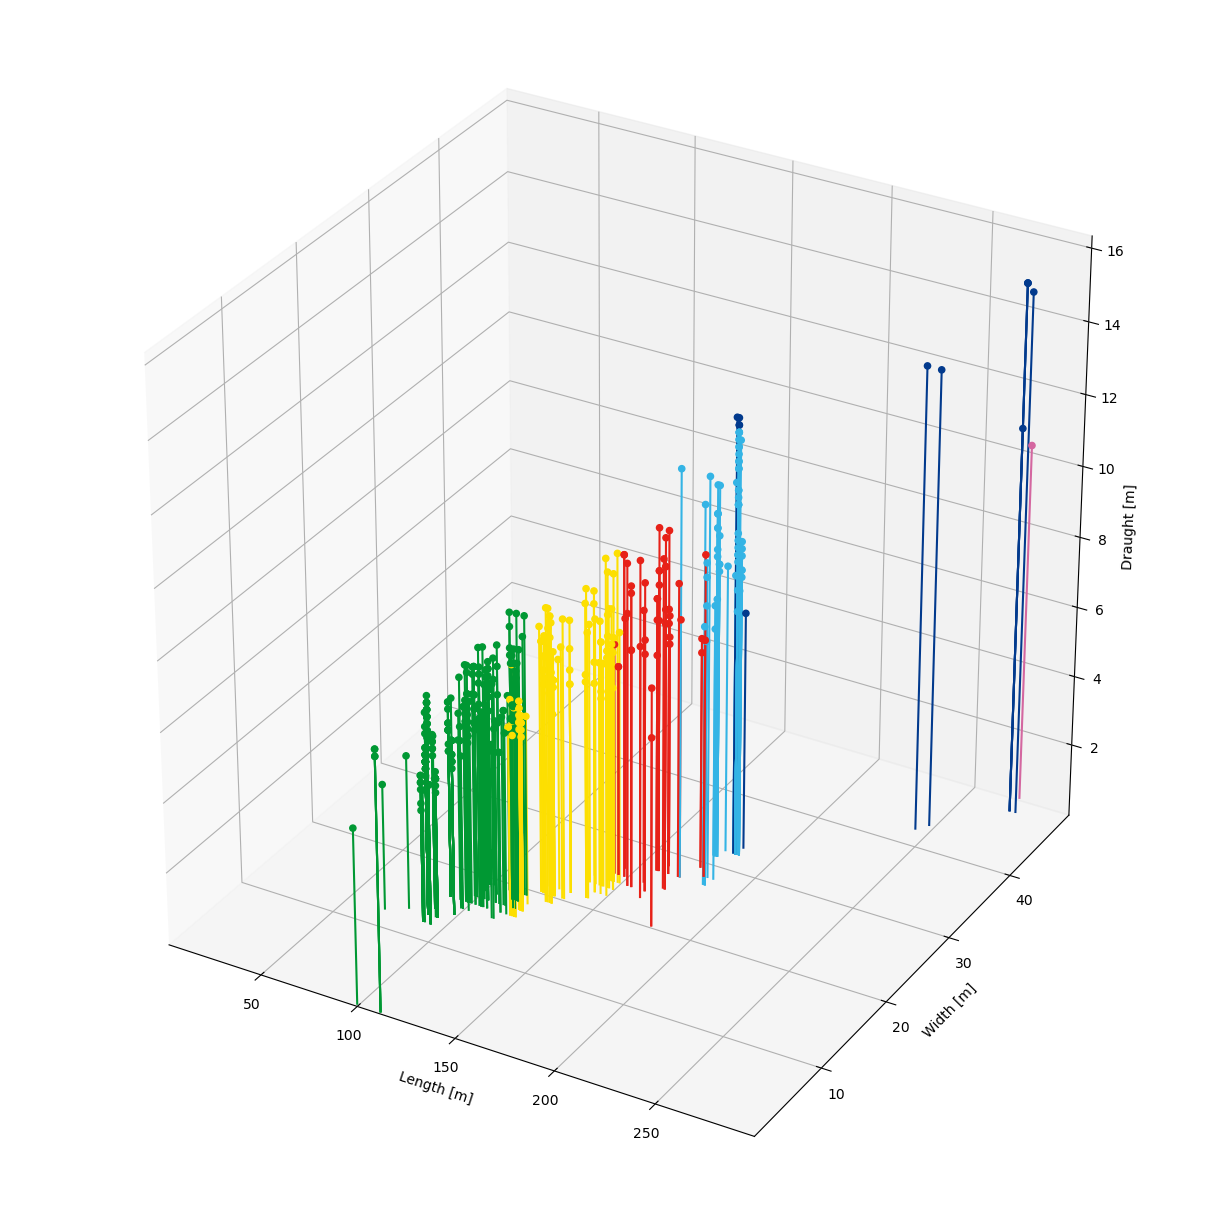

In [29]:
fig = plt.figure(figsize=(12, 12))
ax = Axes3D(fig)
L = origin_destination_matrix.length.to_numpy()
B = origin_destination_matrix.width.to_numpy()
T = origin_destination_matrix.draught.to_numpy()

ax.scatter(L,B,T,c=color,depthshade=False,zorder=0)
for l,b,t,c in zip(L,B,T,color):
    ax.plot([l,l],[b,b],[0,t],c=c,zorder=1)

ax.set_xlim(0,292.5)
ax.set_ylim(0,49)
ax.set_zlim(0,16)
ax.set_xlabel('Length [m]')
ax.set_ylabel('Width [m]')
ax.set_zlabel('Draught [m]')
ax.set_xbound(7.5)
ax.set_ybound(1)
ax.set_zbound(0.25)

plt.show()

In [30]:
def create_vessel(Vessel,env,name,origin,destination,next_destination,beam,length,draught,delta_draught,berthing_time,unloading_time,turning_time,arrival_time,terminal_of_call,berth_of_call,additional_waiting_time,bound='inbound',height=0.,ukc=0.,max_cross_current=0.):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     "next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination[0]),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     "t_berthing":berthing_time.total_seconds(),
                     "t_(un)loading":[time.total_seconds() for time in unloading_time],
                     "t_turning":[time.total_seconds() for time in turning_time],
                     "ukc":ukc,
                     "v":np.NaN,
                     "terminal_of_call": terminal_of_call,
                     "berth_of_call": berth_of_call,
                     "(un)loading": delta_draught,
                     "max_waiting_time":datetime.timedelta(days=5).total_seconds(),
                     "max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     "arrival_delay":arrival_time,
                     "priority": 0,
                     "additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     "bound":bound,
                     "priority":False}
    
    created_vessel = Vessel(**vessel_input)
    return created_vessel

In [31]:
origin_destination_matrix['arrival_time'] = origin_destination_matrix['arrival']+origin_destination_matrix['waiting_time_in_anchorage']
origin_destination_matrix['departure_time'] = origin_destination_matrix['arrival_time']+origin_destination_matrix['(un)loading time']
origin_destination_matrix['berth_of_call'] = [berth.split('Koole_')[1] for berth in origin_destination_matrix['berth_of_call']]
corrected_origin_destination_matrix = origin_destination_matrix.copy()
for column in origin_destination_matrix.columns:
    origin_destination_matrix[column] = origin_destination_matrix[column].astype('object')
for name in list(dict.fromkeys(origin_destination_matrix.name)):
    df_ship = origin_destination_matrix[origin_destination_matrix.name == name]
    if len(df_ship) > 1:
        remove_indexes = []
        trip_merge = False
        for (_,prev_row),(_,next_row) in zip(df_ship.iloc[:-1].iterrows(),df_ship.iloc[1:].iterrows()):
            if next_row.arrival_time - prev_row.departure_time < pd.Timedelta(2,'h') and next_row.origin_node in ['8866999','8866859']:
                if not trip_merge:
                    merge_loc = prev_row.name
                    trip_merge = True
                if trip_merge: 
                    remove_indexes.append(next_row.name)
                    for column in ['(un)loading','berth_of_call','(un)loading time','berth_node','destination_node','turning_time']:
                        origin_destination_matrix.at[merge_loc,column] = list(np.append(np.array(origin_destination_matrix.loc[merge_loc,column]),next_row[column]))   
            elif trip_merge:        
                trip_merge = False
        origin_destination_matrix = origin_destination_matrix.drop(remove_indexes)     

In [32]:
for column in ['(un)loading','berth_of_call','turning_time','(un)loading time','berth_node','destination_node']:
    values = []
    for value in origin_destination_matrix[column].to_numpy():
        if not isinstance(value,list):
            values.append([value])
        else:
            values.append(value)
    origin_destination_matrix[column] = values

In [33]:
for index in [12,109,156,175]:
    origin_destination_matrix.loc[index,'(un)loading'] = [np.max(origin_destination_matrix.loc[index]['(un)loading'])]
    origin_destination_matrix.loc[index,'berth_of_call'] = [origin_destination_matrix.loc[index]['berth_of_call'][0]]
    origin_destination_matrix.loc[index,'turning_time'] = [origin_destination_matrix.loc[index]['turning_time'][0]]
    origin_destination_matrix.loc[index,'(un)loading time'] = [np.sum(origin_destination_matrix.loc[index]['(un)loading time'])]
    origin_destination_matrix.loc[index,'destination_node'] = [origin_destination_matrix.loc[index]['destination_node'][-1]]

In [34]:
origin_destination_matrix[origin_destination_matrix.trip_id == 'testschip-1635_1']

,name,trip_id,length,width,draught,(un)loading,berth_of_call,arrival,waiting_time_in_anchorage,turning_time,(un)loading time,origin_node,berth_node,destination_node,arrival_time,departure_time
156,testschip-1635,testschip-1635_1,112.0,0.0,7.2,[1.5999999046325684],[Buiten9],2019-05-08 05:50:42+00:00,0 days 10:03:09,[0 days 00:02:41],[1 days 05:22:07],8866969,"[8866859, 8866859]",[8866969],2019-05-08 15:53:51+00:00,2019-05-08 22:51:00+00:00


In [35]:
for index in origin_destination_matrix[origin_destination_matrix.origin_node == '8866859'].index:
    origin_destination_matrix.loc[index,'origin_node'] = '8866999'

In [36]:
origin_destination_matrix

,name,trip_id,length,width,draught,(un)loading,berth_of_call,arrival,waiting_time_in_anchorage,turning_time,(un)loading time,origin_node,berth_node,destination_node,arrival_time,departure_time
0,testschip-1481,testschip-1481_0,79.0,16.0,5.0,[-0.40000009536743164],[Kade_H],2019-01-01 11:44:14+00:00,0 days 00:00:00,[0 days 00:17:19],[0 days 09:16:40],8866969,[8866859],[8864069],2019-01-01 11:44:14+00:00,2019-01-01 21:00:54+00:00
1,testschip-1791,testschip-1791_0,89.0,13.0,4.4,[0.0],[Kade_H],2019-01-02 08:16:33+00:00,0 days 00:00:00,[0 days 00:02:02],[0 days 06:47:34],8866969,[8866859],[8864069],2019-01-02 08:16:33+00:00,2019-01-02 15:04:07+00:00
2,testschip-2295,testschip-2295_0,106.0,16.0,5.8,[-0.5999999046325684],[Kade11],2019-01-03 05:25:35+00:00,0 days 04:13:49,[0 days 00:12:40],[0 days 18:44:49],8866969,[8866859],[8866969],2019-01-03 09:39:24+00:00,2019-01-04 04:24:13+00:00
3,testschip-2747,testschip-2747_0,116.0,19.0,7.0,[1.5999999046325684],[Buiten9],2019-01-04 12:01:43+00:00,0 days 00:00:00,[0 days 00:01:38],[1 days 01:30:03],8866969,[8866859],[8866969],2019-01-04 12:01:43+00:00,2019-01-05 13:31:46+00:00
4,testschip-3417,testschip-3417_0,104.0,17.0,5.2,[-2.0],[Kade11],2019-01-05 17:03:49+00:00,1 days 16:40:10,[0 days 00:01:00],[2 days 12:44:51],8866969,[8866859],[8866969],2019-01-07 09:43:59+00:00,2019-01-09 22:28:50+00:00
5,testschip-2718,testschip-2718_0,183.0,32.0,11.0,[4.0],[Kade11],2019-01-06 02:44:47+00:00,0 days 00:00:00,[0 days 00:08:30],[1 days 01:02:56],8866999,[8866859],[8866969],2019-01-06 02:44:47+00:00,2019-01-07 03:47:43+00:00
6,testschip-3491,testschip-3491_0,100.0,16.0,6.0,[-0.8000001907348633],[Buiten9],2019-01-07 01:33:21+00:00,0 days 12:24:01,[0 days 00:05:41],[1 days 01:53:19],8866969,[8866859],[8866969],2019-01-07 13:57:22+00:00,2019-01-08 15:50:41+00:00
7,testschip-3744,testschip-3744_0,159.0,27.0,7.2,[2.0],[Buiten9],2019-01-08 16:45:49+00:00,0 days 01:57:01,[0 days 00:10:50],[1 days 06:39:25],8866969,[8866859],[8864069],2019-01-08 18:42:50+00:00,2019-01-10 01:22:15+00:00
8,testschip-3981,testschip-3981_0,183.0,32.0,7.0,[0.0],[Buiten9],2019-01-10 01:01:32+00:00,0 days 03:06:00,[0 days 00:21:08],[0 days 20:38:50],8866969,[8866859],[8867571],2019-01-10 04:07:32+00:00,2019-01-11 00:46:22+00:00
9,testschip-4407,testschip-4407_0,145.0,23.0,6.4,[-2.4000000953674316],[Kade11],2019-01-10 02:21:30+00:00,2 days 10:51:02,[0 days 00:09:11],[1 days 23:49:17],8866969,[8866859],[8866969],2019-01-12 13:12:32+00:00,2019-01-14 13:01:49+00:00


In [37]:
def calculate_additional_waiting_time(trip_id1,trip_id2):
    arrival_time1 = origin_destination_matrix[origin_destination_matrix.trip_id == trip_id1].iloc[0].arrival
    arrival_time2 = origin_destination_matrix[origin_destination_matrix.trip_id == trip_id2].iloc[0].arrival
    delay = arrival_time2 - arrival_time1
    return {trip_id1:delay}

In [38]:
additional_waiting_times = {}
# additional_waiting_times = {**calculate_additional_waiting_time('testschip-3417_0','testschip-2718_0'), #5.2 on 11.0
#                             **calculate_additional_waiting_time('testschip-4407_0','testschip-4157_0'), #6.2 on 11.8
#                             **calculate_additional_waiting_time('testschip-1186_0','testschip-3491_1'), #4.0 on 6.8
#                             **calculate_additional_waiting_time('testschip-8014_0','testschip-1635_0'), #5.4 on 7.4
#                             **calculate_additional_waiting_time('testschip-9416_0','testschip-4025_0'), #testschip-3144_1
#                             **calculate_additional_waiting_time('testschip-3005_0','testschip-4815_1'),
#                             **calculate_additional_waiting_time('testschip-12542_0','testschip-12705_0'),
#                             **calculate_additional_waiting_time('testschip-2817_1','testschip-1290_1'), #testschip-12198_0
#                             **calculate_additional_waiting_time('testschip-3762_1','testschip-1587_5'),
#                             **calculate_additional_waiting_time('testschip-6532_1','testschip-5133_1'),
#                             **calculate_additional_waiting_time('testschip-8702_0','testschip-14181_0'),
#                             **calculate_additional_waiting_time('testschip-5981_0','testschip-4723_1'),
#                             **calculate_additional_waiting_time('testschip-9057_0','testschip-14377_0'),
#                             **calculate_additional_waiting_time('testschip-3688_0','testschip-4269_1'),
#                             **calculate_additional_waiting_time('testschip-17119_0','testschip-1587_9'),
#                             **calculate_additional_waiting_time('testschip-9057_1','testschip-5202_2'),
#                             **calculate_additional_waiting_time('testschip-3491_2','testschip-6922_0'),
#                             **calculate_additional_waiting_time('testschip-8702_1','testschip-1191_1'),
#                             **calculate_additional_waiting_time('testschip-4683_0','testschip-18879_0'),
#                             **calculate_additional_waiting_time('testschip-7523_0','testschip-4908_12'),
#                             **calculate_additional_waiting_time('testschip-5108_1','testschip-5218_1'), #testschip-4723_2
#                             **calculate_additional_waiting_time('testschip-4723_2','testschip-5218_1'),
#                             **calculate_additional_waiting_time('testschip-4352_0','testschip-4723_3'),
#                             **calculate_additional_waiting_time('testschip-1186_7','testschip-6052_3'),
#                             **calculate_additional_waiting_time('testschip-4843_2','testschip-20371_0'),
#                             **calculate_additional_waiting_time('testschip-2343_0','testschip-20933_0'), #estschip-9320_0
#                             **calculate_additional_waiting_time('testschip-19943_0','testschip-5459_1'), #testschip-4810_1 #testschip-21204_0 #testschip-21279_0
#                             **calculate_additional_waiting_time('testschip-4948_2','testschip-12657_1'),
#                             **calculate_additional_waiting_time('testschip-9416_1','testschip-6409_2'),
#                             **calculate_additional_waiting_time('testschip-6903_0','testschip-8786_0'), #testschip-6052_4
#                             **calculate_additional_waiting_time('testschip-6782_2','testschip-18514_0'),
#                             **calculate_additional_waiting_time('testschip-4955_2','testschip-12657_2'),
#                             **calculate_additional_waiting_time('testschip-2528_1','testschip-9592_0')}
# additional_waiting_times['testschip-5108_1']+=np.timedelta64(1,'s')

In [39]:
list_of_vessels = []
for loc,info in origin_destination_matrix.iterrows():
    Vessel = type('Vessel', (core.SimpyObject,core.Identifiable, port.HasPortAccess, port.HasAnchorage, port.HasTurningBasin, port.HasTerminal, core.Movable, core.Routeable, vessel_.VesselProperties, output.HasOutput, vessel_.ExtraMetadata), {}) #waterway.HasWaterway
    if info.origin_node in ['8868178','8866859','8866999']:
        bound = 'outbound'
    else:
        bound = 'inbound'
    if info.trip_id in additional_waiting_times.keys():
        additional_waiting_time = additional_waiting_times[info.trip_id]
    else:
        additional_waiting_time = np.timedelta64(0,'s')
    
    created_vessel = create_vessel(Vessel,
                                   env,
                                   name=info['name'],
                                   origin=info['origin_node'],
                                   destination=np.append([],info['berth_node']),
                                   next_destination=np.append([],info['destination_node']),
                                   beam=info['width'],
                                   length=info['length'],
                                   draught=info['draught'],
                                   delta_draught=np.append([],info['(un)loading']),
                                   berthing_time=pd.Timedelta(1,'s'),
                                   unloading_time=np.append([],info['(un)loading time']),
                                   turning_time=np.append([],np.min([pd.Timedelta(15,'m'),info['turning_time'][0]])),
                                   arrival_time=info['arrival']+pd.Timedelta(1,'h'),
                                   terminal_of_call=np.array(['Koole' for i in range(len(list(info['berth_of_call'])))]),
                                   berth_of_call=np.array(info['berth_of_call']),
                                   additional_waiting_time = additional_waiting_time,
                                   bound=bound)
    list_of_vessels.append(created_vessel)

In [40]:
for index,vessel in enumerate(list_of_vessels):
    sim.add_vessels(vessel=vessel)

## Generate infrastructure

In [41]:
Koole_berths = pd.DataFrame({'MBL':[12.65,8.15,8.15,8.15,17,12.65,6.8,15.9,15.9],
                             'Length':[250,253.5,253.5,140,395,250,162,222,253]},
                            index=['Kade11','Kade_G','Kade_H','Binnen10','Buiten10','Buiten9','Binnen7','Buiten7','Buiten6'])
Koole_berths.index.name = 'Berth'

In [42]:
#(Change infrastructure capacities here)
turning_basin_1 = port.IsTurningBasin(env = env, name = 'Turning Basin 1', information = {'Length': 300})
anchorage_1 = port.IsAnchorage(env = env, name = 'Anchorage 1', capacity = 50)
terminal_1 = port.IsJettyTerminal(env=env,name = 'Koole terminal',type='jetty',information=Koole_berths)

## Assign infrastructure to graph

In [43]:
FG.nodes['anchorage']["Anchorage"] = [anchorage_1]
FG.edges['8866999', '8866859',0]["Terminal"] = {'Koole':terminal_1}
FG.nodes['8866999']["Turning Basin"] = [turning_basin_1]
        
# for node in FG.nodes:
#     number_of_edges = 0
#     for edge in FG.edges:
#         if node == edge[0]:
#             number_of_edges+=1
#     if number_of_edges != 2:
#         FG.nodes[node]["Junction"] = []

# junction_nodes = []
# for node in list(FG.nodes):
#     if 'Junction' in FG.nodes[node]:
#         junction_nodes.append(node)
        
# for node1 in junction_nodes:
#     names = []
#     sections = []
#     types = []
#     for node2 in junction_nodes:
#         if node1 == node2:
#             continue

#         route = nx.dijkstra_path(FG, node1, node2)
#         section = True
#         for node in route[1:-1]:
#             if 'Junction' in FG.nodes[node]:
#                 section = False
#                 break

#         if section:
#             sections.append([route[0],route[-1]])
    
#     FG.nodes[node1]["Junction"] = waterway.IsWaterwayJunction(env = env, 
#                                                               name = node1, 
#                                                               sections = sections, 
#                                                               detector_nodes = [node1,node2])

## Append the tidal restriction to the network

In [44]:
#Conversion kn to m/s
knots = 0.51444

#Restrictions as dictionaries
for node in env.FG.nodes:
    env.FG.nodes[node]['Info'] = {}
    env.FG.nodes[node]['Info']['Vertical tidal restriction'] = {}
env.FG.nodes['8861158']['Info']['Horizontal tidal restriction'] = {}

In [45]:
network_properties = tidal_window_constructor.NetworkProperties()

### Vertical tidal window

In [46]:
#According to Port of Rotterdam Policy (Change here the ukc policy)
ukc_p = []
ukc_s = []
fwa = []
        
for node in env.FG.nodes:
    if node in ['8866969','8866305','8864266','8862925','8864465','S14716_B','S14716_A','8860845']:
        ukc_s.append(0.)
        ukc_p.append(0.1)
        fwa.append(0.01)
    elif node in ['8867547','8867980','8866999']:
        ukc_s.append(1.0)
        ukc_p.append(0.0)
        fwa.append(0.025)
    elif node in ['8866859']:
        ukc_s.append(0.5)
        ukc_p.append(0.0)
        fwa.append(0.025)
    elif node in ['anchorage']:
        ukc_s.append(0.0)
        ukc_p.append(0.0)
        fwa.append(0.0)
    else:
        ukc_s.append(0.0)
        ukc_p.append(0.1)
        fwa.append(0.025)
        
for index,node in enumerate(FG.nodes):
    vertical_tidal_window_inputs = []

    #Inbound_Vessels_Condition
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 0},
                                                                           'x',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index],
                                                                                         ukc_p = ukc_p[index],
                                                                                         fwa = fwa[index],)
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

    #Outbound_Vessels_Condition
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 0},
                                                                           'x',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index],
                                                                                         ukc_p = ukc_p[index],
                                                                                         fwa = fwa[index],)

    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

    network_properties.append_vertical_tidal_restriction_to_network(FG,node,vertical_tidal_window_inputs)

### Horizontal tidal window

In [47]:
#Port of Rotterdam Policy 3rd Petroleum Harbour
previous_nodes = ['8861716','8861674']
node = '8861158'
next_node = '8867547'
knots = 0.5144444
horizontal_tidal_window_inputs = []
scheurkade_data = hydrodynamic_data.sel({'STATION':'Scheurkade'})
scheurkade_data['TIME'] = scheurkade_data.TIME.values - np.timedelta64(20,'m')

for previous_node in previous_nodes:
    #Inbound_Vessels_Condition1
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Length: 180,
                                                                           rule_constructor.vessel_characteristics.min_ge_Draught: 11.0,
                                                                           rule_constructor.vessel_characteristics.max_lt_Draught: 14.3},
                                                                           '(x and x and x)',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.maximum.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: 2*knots,tidal_window_constructor.tidal_period.Ebb.value: 2*knots})


    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': previous_node, 'Destination': next_node},
                                                                                                 data = scheurkade_data))
    #Inbound_Vessels_Condition2
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 14.3},
                                                  'x',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.point_based.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: [1.3*0.5*knots,0.7*0.5*knots],tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.inaccessible.value})

    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': previous_node, 'Destination': next_node},
                                                                                                 data = scheurkade_data))

    #Outbound_Vessels_Condition1  
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.max_lt_Draught: 14.3},
                                                                           'x',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.maximum.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: 2*knots,tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.accessible.value})


    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': next_node, 'Destination': previous_node},
                                                                                                 data = scheurkade_data))

    #Outbound_Vessels_Condition2
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 14.3},
                                                  'x',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.point_based.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: [1.3*0.5*knots,0.7*0.5*knots],tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.inaccessible.value})

    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': next_node, 'Destination': previous_node},
                                                                                                 data = scheurkade_data))

network_properties.append_horizontal_tidal_restriction_to_network(FG,node,horizontal_tidal_window_inputs)

## Initiation of the simulation

In [48]:
t1 = timpie.time()
sim.run()
t2 = timpie.time()
print('total simulation time:', t2-t1)

C:\Users\floorbakker\Anaconda3\envs\opentnsim\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

C:\Users\floorbakker\Anaconda3\envs\opentnsim\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\floorbakker\Anaconda3\envs\opentnsim\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

C:\Users\floorbakker\Anaconda3\envs\opentnsim\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



total simulation time: 446.8151009082794


In [49]:
terminal = FG.edges['8866859','8866999',0]['Terminal']['Koole']

In [50]:
for item in terminal.resource.items:
    print(item.name)

Binnen7
Buiten7
Buiten6
Binnen10
Kade_G
Kade_H
Buiten10
Buiten9


## Output

In [51]:
vessels = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 
env = sim.environment #extract the environment itself

### Anchorage

In [52]:
df = pd.DataFrame.from_dict(FG.nodes['anchorage']['Anchorage'][0].log)
df

,Time,Location,Action,Status
0,2019-01-10 01:01:32.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
1,2019-01-10 01:01:32.000000,POINT (4.04470684375659 51.9905399816771),Vessel departure,"{'vessel_information': {'origin': '8866969', '..."
2,2019-01-10 16:57:24.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
3,2019-01-12 02:20:00.000000,POINT (4.04470684375659 51.9905399816771),Vessel departure,"{'vessel_information': {'origin': '8866969', '..."
4,2019-01-12 11:59:05.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
5,2019-01-12 18:32:23.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
6,2019-01-13 16:56:20.000000,POINT (4.04470684375659 51.9905399816771),Vessel departure,"{'vessel_information': {'origin': '8866969', '..."
7,2019-01-13 20:47:39.000000,POINT (4.04470684375659 51.9905399816771),Vessel arrival,"{'vessel_information': {'origin': '8866969', '..."
8,2019-01-14 14:27:09.000000,POINT (4.04470684375659 51.9905399816771),Vessel departure,"{'vessel_information': {'origin': '8866969', '..."
9,2019-01-15 21:30:04.359823,POINT (4.04470684375659 51.9905399816771),Vessel departure,"{'vessel_information': {'origin': '8866969', '..."


### Turning basin

In [53]:
df = pd.DataFrame.from_dict(FG.nodes['8866999']['Turning Basin'][0].log)
df

,Time,Location,Action,Status
0,2019-01-01 13:41:28.359823,POINT (4.3079461632343 51.880438540609305),Turning start,"{'vessel_information': {'origin': '8866969', '..."
1,2019-01-01 13:56:28.359823,POINT (4.3079461632343 51.880438540609305),Turning stop,"{'vessel_information': {'origin': '8866969', '..."
2,2019-01-01 23:13:10.359823,POINT (4.3079461632343 51.880438540609305),Vessel Passing,"{'vessel_information': {'origin': '8866969', '..."
3,2019-01-02 10:13:47.359823,POINT (4.3079461632343 51.880438540609305),Turning start,"{'vessel_information': {'origin': '8866969', '..."
4,2019-01-02 10:15:49.359823,POINT (4.3079461632343 51.880438540609305),Turning stop,"{'vessel_information': {'origin': '8866969', '..."
...,...,...,...,...
1428,2019-12-30 20:18:37.870028,POINT (4.3079461632343 51.880438540609305),Vessel Passing,"{'vessel_information': {'origin': '8863623', '..."
1429,2019-12-31 01:43:32.359823,POINT (4.3079461632343 51.880438540609305),Vessel Passing,"{'vessel_information': {'origin': '8863623', '..."
1430,2019-12-31 02:11:52.245450,POINT (4.3079461632343 51.880438540609305),Vessel Passing,"{'vessel_information': {'origin': '8863623', '..."
1431,2019-12-31 11:57:29.829514,POINT (4.3079461632343 51.880438540609305),Turning start,"{'vessel_information': {'origin': '8860727', '..."


### Terminal

In [54]:
terminal = FG.edges['8866859','8866999',0]['Terminal']['Koole']
df = pd.DataFrame.from_dict(terminal.log) #creates a data frame with all the info of vessels[0].
df.head(n=60)

,Time,Location,Action,Status
0,2019-01-01 13:56:28.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
1,2019-01-01 23:13:10.359823,POINT (4.3079461632343 51.880438540609305),Departure of vessel,"{'vessel_information': {'origin': '8866969', '..."
2,2019-01-02 10:15:49.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
3,2019-01-02 17:03:25.359823,POINT (4.3079461632343 51.880438540609305),Departure of vessel,"{'vessel_information': {'origin': '8866969', '..."
4,2019-01-03 07:35:29.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
5,2019-01-04 02:20:20.359823,POINT (4.3079461632343 51.880438540609305),Departure of vessel,"{'vessel_information': {'origin': '8866969', '..."
6,2019-01-04 14:00:35.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
7,2019-01-05 15:30:40.359823,POINT (4.3079461632343 51.880438540609305),Departure of vessel,"{'vessel_information': {'origin': '8866969', '..."
8,2019-01-05 19:02:03.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."
9,2019-01-07 03:36:16.359823,POINT (4.3079461632343 51.880438540609305),Arrival of vessel,"{'vessel_information': {'origin': '8866969', '..."


### Vessel

In [55]:
output_df = pd.DataFrame(columns=['Shipname','Length','Beam','Trip_number','Origin','Destination','Routes','Anchorage_area',
                                  'Waiting_time_in_anchorage','Waiting_time_at_terminal','Turning_basin','Turning_time',
                                  'Terminal_of_call','Berth_of_call','(Un)loading_time','Total_sailing_time','Times',
                                  'Actions','Location','Nodes','Sailing_distance','Speed','Heading','Draught','MBL',
                                  'Net_UKC','Gross_UKC','Ship_related_factors','Water_level','Limiting_current_velocity'])
for vessel in vessels:
    df = pd.DataFrame.from_dict(vessel.log)
    if vessel.output['sailed_routes']:
        output_df = pd.concat([output_df,pd.DataFrame(data=[[vessel.name, #'Shipname'   
                                                             vessel.L, #'Length'
                                                             vessel.B, #'Beam'
                                                             0, #'Trip_number'
                                                             vessel.output['sailed_routes'][0][0], #'Origin'
                                                             vessel.output['sailed_routes'][-1][-1], #'Destination'
                                                             vessel.output['sailed_routes'], #'Routes' 
                                                             vessel.output['visited_anchorages'], #'Anchorage_area'
                                                             vessel.output['waiting_times_in_anchorages'], #'Waiting_time_in_anchorage'
                                                             vessel.output['waiting_times_at_terminals'], #'Waiting_time_in_anchorage'
                                                             vessel.output['visited_turning_basins'], #'Turning_basin'
                                                             vessel.output['turning_times'], #'Turning_time'
                                                             vessel.output['visited_terminals'], #'Terminal_of_call'
                                                             vessel.output['visited_berths'], #'Berth_of_call'
                                                             vessel.output['(un)loading_times'], #'(Un)loading_time'
                                                             np.array([status['sailing_time'] for status in df.Status.to_numpy()]).sum(), #'Total_sailing_time'
                                                             df.Time.to_numpy(), #'Times'
                                                             df.Action.to_numpy(), #'Actions'
                                                             df.Location.to_numpy(), #'Location'
                                                             np.array([status['current_node'] for status in df.Status.to_numpy()]), #'Nodes'
                                                             np.array([status['sailing_distance'] for status in df.Status]), #'Sailing_distance'
                                                             np.array([status['speed'] for status in df.Status.to_numpy()]), #'Speed'
                                                             np.array([status['heading'] for status in df.Status.to_numpy()]), #'Heading'
                                                             np.array([status['draught'] for status in df.Status.to_numpy()]), #'Draught'
                                                             np.array([status['MBL'] for status in df.Status.to_numpy()]), #'MBL'
                                                             np.array([status['net_ukc'] for status in df.Status.to_numpy()]), #'Net_UKC'
                                                             np.array([status['gross_ukc'] for status in df.Status.to_numpy()]), #'Gross_UKC'
                                                             np.array([status['ship_related_ukc_factors'] for status in df.Status.to_numpy()]), #'Ship_related_factors'
                                                             np.array([status['water_level'] for status in df.Status.to_numpy()]), #'Water_level'
                                                             np.array([status['limiting current velocity'] for status in df.Status.to_numpy()])]], #'Limiting_current_velocity'
                                                      columns=output_df.columns)])

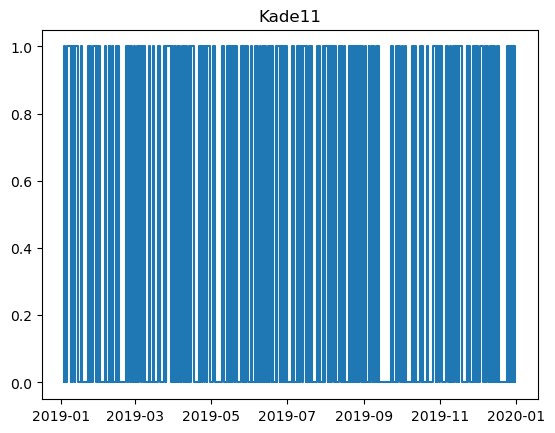

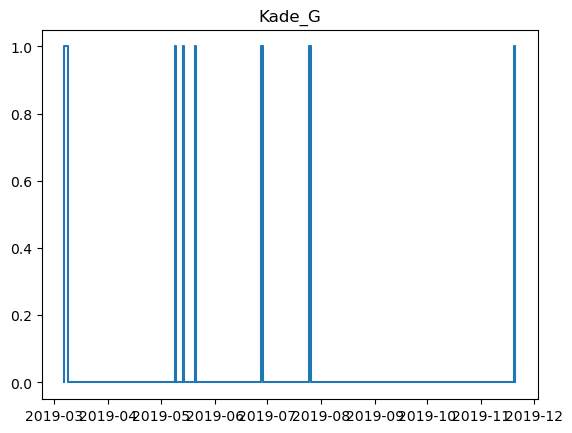

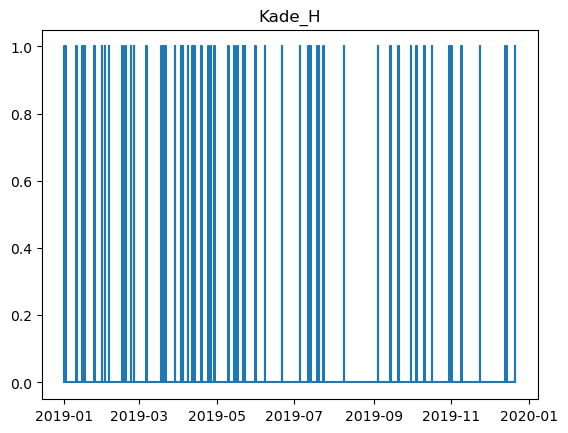

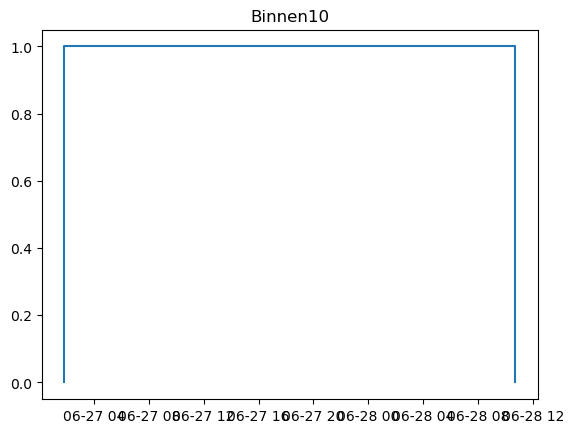

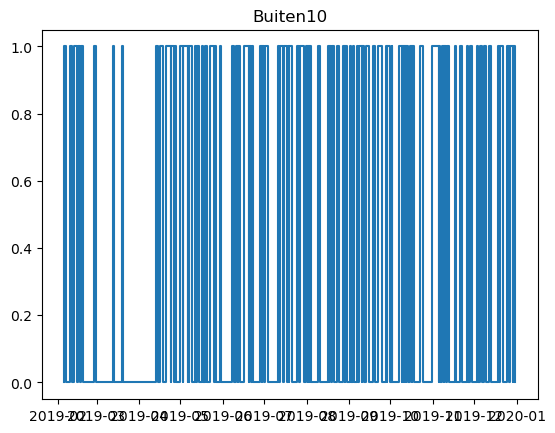

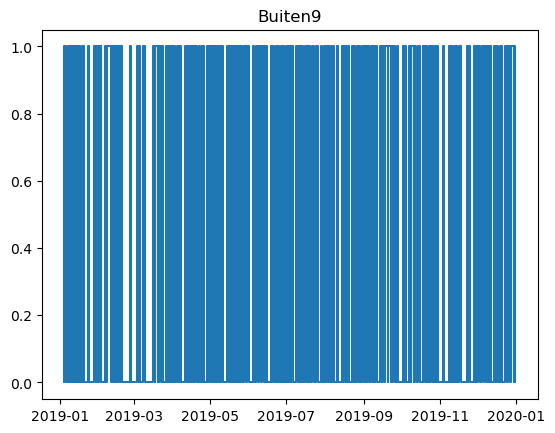

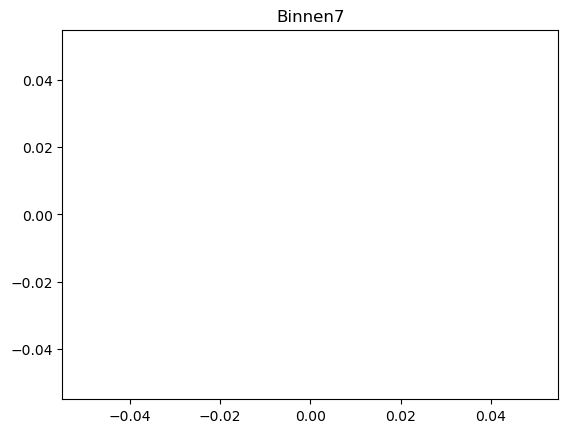

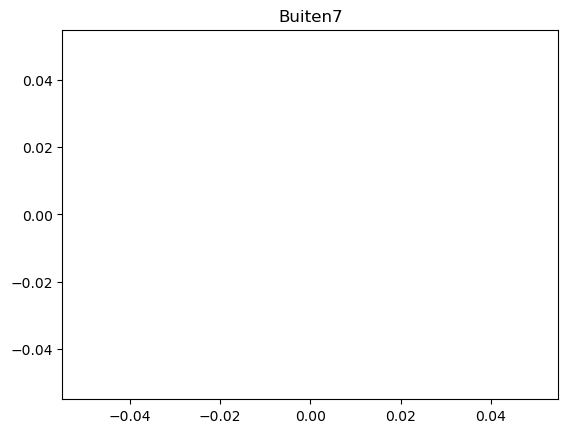

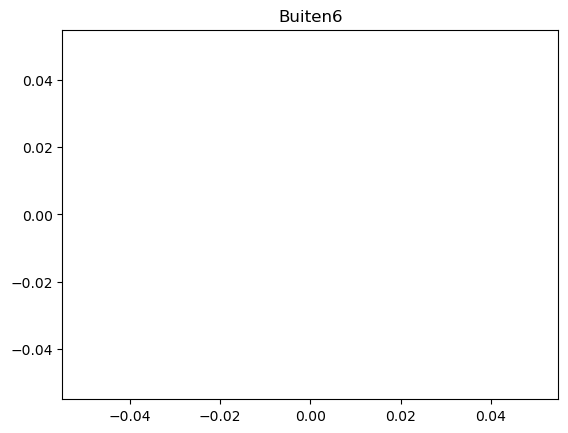

In [56]:
terminal = FG.edges['8866859','8866999',0]['Terminal']['Koole']
df = pd.DataFrame.from_dict(terminal.log) #creates a data frame with all the info of vessels[0].
for berth in Koole_berths.index:
    times = []
    occupied = []
    for loc,info in df.iterrows():
        if info.Action == 'Departure of vessel' and info.Status['vessel_information']['berth'] == berth:
            times.append(datetime.datetime.fromtimestamp(info.Status['vessel_arrival']))
            occupied.append(0)
            times.append(datetime.datetime.fromtimestamp(info.Status['vessel_arrival']))
            occupied.append(1)
            times.append(datetime.datetime.fromtimestamp(info.Status['vessel_departure']))
            occupied.append(1)
            times.append(datetime.datetime.fromtimestamp(info.Status['vessel_departure']))
            occupied.append(0)
    plt.plot(times,occupied)
    plt.title(berth)
    #plt.xlim([np.datetime64('2019-03-06 06:52:08'),np.datetime64('2019-03-06 06:52:08')+np.timedelta64(5,'D')])
    plt.show()

In [57]:
len(output_df)

481

In [58]:
output_df = output_df.reset_index(drop=True)
output_df['Trip_id'] = output_df['Shipname']+'_0'

In [59]:
for name in list(dict.fromkeys(output_df.Shipname)):
    in_df = origin_destination_matrix[origin_destination_matrix.name == name]
    out_df = output_df[output_df.Shipname == name]
    for trip_id,loc in enumerate(out_df.index):
        output_df.loc[loc,'Trip_id'] = in_df.iloc[trip_id].trip_id

In [60]:
waiting_time_comparison = {}
for loc,trip_id in enumerate(output_df.Trip_id):
    modelled_waiting_time_in_anchorage = output_df.loc[loc].Waiting_time_in_anchorage
    modelled_waiting_time_at_terminal = output_df.loc[loc].Waiting_time_at_terminal

In [61]:
waiting_time_comparison = {}
for loc,trip_id in enumerate(output_df.Trip_id):
    modelled_waiting_time_in_anchorage = output_df.loc[loc].Waiting_time_in_anchorage
    modelled_waiting_time_at_terminal = output_df.loc[loc].Waiting_time_at_terminal
    if modelled_waiting_time_in_anchorage:
        total_waiting_time = np.sum(list(modelled_waiting_time_in_anchorage[0].values()))
        waiting_for_available_terminal = modelled_waiting_time_in_anchorage[0]['Availability']
        waiting_for_tidal_window = modelled_waiting_time_in_anchorage[0]['Tidal window']
        waiting_due_to_priority = modelled_waiting_time_in_anchorage[0]['Priority']
    elif modelled_waiting_time_at_terminal:
        total_waiting_time = np.sum(list(modelled_waiting_time_at_terminal[0][0].values()))
        waiting_for_available_terminal = modelled_waiting_time_at_terminal[0][0]['Availability']
        waiting_for_tidal_window = modelled_waiting_time_at_terminal[0][0]['Tidal window']
        waiting_due_to_priority =  modelled_waiting_time_at_terminal[0][0]['Priority']
    else:
        total_waiting_time = pd.Timedelta(0,'s')
        waiting_due_to_priority = pd.Timedelta(0,'s')
        waiting_for_tidal_window = pd.Timedelta(0,'s')
        waiting_for_available_terminal = pd.Timedelta(0,'s')
    if modelled_waiting_time_at_terminal:
        total_waiting_time += np.sum(list(modelled_waiting_time_at_terminal[0][-1].values()))
        outbound_waiting_for_available_terminal = modelled_waiting_time_at_terminal[0][-1]['Availability']
        outbound_waiting_for_tidal_window = modelled_waiting_time_at_terminal[0][-1]['Tidal window']
        outbound_waiting_due_to_priority =  modelled_waiting_time_at_terminal[0][-1]['Priority']
    else:
        outbound_waiting_due_to_priority = pd.Timedelta(0,'s')
        outbound_waiting_for_tidal_window = pd.Timedelta(0,'s')
        outbound_waiting_for_available_terminal = pd.Timedelta(0,'s')
        
    
    waiting_time_comparison[trip_id] = [waiting_for_tidal_window,
                                        waiting_for_available_terminal,
                                        waiting_due_to_priority,
                                        outbound_waiting_due_to_priority,
                                        outbound_waiting_for_available_terminal,
                                        outbound_waiting_for_tidal_window,
                                        total_waiting_time,
                                        origin_destination_matrix[origin_destination_matrix.trip_id == trip_id].waiting_time_in_anchorage.to_numpy()[0]]

In [62]:
comparison_df = pd.DataFrame.from_dict(waiting_time_comparison,orient='index',columns=['Waiting_for_tidal_window_inbound',
                                                                                       'Waiting_for_available_berth_inbound',
                                                                                       'Waiting_due_to_priority_inbound',
                                                                                       'Waiting_due_to_priority_outbound',
                                                                                       'Waiting_for_available_berth_outbound',
                                                                                       'Waiting_for_tidal_window_outbound',
                                                                                       'Modelled_total_waiting_time',
                                                                                       'Observed_total_waiting_time'])
for index in comparison_df[pd.isnull(comparison_df['Observed_total_waiting_time'].to_numpy())].index:
    comparison_df.loc[index,'Observed_total_waiting_time'] = np.timedelta64(0,'s')

In [63]:
turnaround_time = []
for vessel in vessels:
    turnaround_time.append(vessel.log['Time'][-1]-vessel.log['Time'][0])

In [64]:
comparison_df['Turnaround_time'] = turnaround_time

In [66]:
with open('model_no_priority.pickle', 'wb') as handle:
    pickle.dump(comparison_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
with open('full_model.pickle', 'rb') as handle:
    full_model_comparison_df = pickle.load(handle)

In [96]:
df = comparison_df#[comparison_df.Waiting_for_tidal_window_inbound > pd.Timedelta(0,'s')]

In [82]:
len(df)

6

In [73]:
np.mean(df.Modelled_total_waiting_time)

Timedelta('0 days 18:52:40.814814814')

In [80]:
np.sum(df.Waiting_for_available_berth_inbound)/np.sum(df.Modelled_total_waiting_time)

0.9932447456104879

In [90]:
df.loc['testschip-17176_0'].Turnaround_time

Timedelta('3 days 13:30:23.897408')

In [89]:
df.loc['testschip-17176_0'].Waiting_for_tidal_window_inbound

Timedelta('0 days 08:18:38')

In [118]:
df.head(n=20)[['Waiting_for_available_berth_inbound','Modelled_total_waiting_time','Observed_total_waiting_time']]

,Waiting_for_available_berth_inbound,Modelled_total_waiting_time,Observed_total_waiting_time
testschip-1481_0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
testschip-1791_0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
testschip-2295_0,0 days 00:00:00,0 days 00:00:00,0 days 04:13:49
testschip-2747_0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
testschip-3417_0,0 days 00:00:00,0 days 00:00:00,1 days 16:40:10
testschip-2718_0,2 days 05:02:09,2 days 05:02:09,0 days 00:00:00
testschip-3491_0,0 days 00:00:00,0 days 00:00:00,0 days 12:24:01
testschip-3744_0,0 days 00:00:00,0 days 00:00:00,0 days 01:57:01
testschip-3981_0,0 days 00:00:00,0 days 00:00:00,0 days 03:06:00
testschip-4407_0,0 days 00:00:00,0 days 00:00:00,2 days 10:51:02


In [122]:
sub_df = full_model_comparison_df.Waiting_for_available_berth_inbound-df.Waiting_for_available_berth_inbound

In [123]:
sub_df

testschip-1481_0      0 days 00:00:00
testschip-1791_0      0 days 00:00:00
testschip-2295_0      0 days 00:00:00
testschip-2747_0      0 days 00:00:00
testschip-3417_0      0 days 23:14:13
testschip-2718_0    -3 days +18:57:51
testschip-3491_0      0 days 00:00:00
testschip-3744_0      0 days 00:00:00
testschip-3981_0      0 days 00:00:00
testschip-4407_0      1 days 17:14:08
testschip-4157_0    -2 days +14:37:24
testschip-1791_1      0 days 00:00:00
testschip-4222_0      0 days 00:00:00
testschip-1186_0      0 days 21:30:49
testschip-3491_1    -2 days +19:02:45
testschip-4696_0      0 days 03:52:53
testschip-4847_0      0 days 03:52:53
testschip-1791_2      0 days 00:00:00
testschip-4843_0      0 days 00:00:00
testschip-1481_1      0 days 00:00:00
testschip-5108_0      0 days 00:00:00
testschip-5077_0      0 days 00:00:00
testschip-1791_3      0 days 00:00:00
testschip-5695_0      0 days 00:00:00
testschip-3283_0      0 days 00:00:00
testschip-3539_0      0 days 00:00:00
testschip-41

In [119]:
full_model_comparison_df.head(n=20)[['Waiting_for_available_berth_inbound','Modelled_total_waiting_time','Observed_total_waiting_time']]

,Waiting_for_available_berth_inbound,Modelled_total_waiting_time,Observed_total_waiting_time
testschip-1481_0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
testschip-1791_0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
testschip-2295_0,0 days 00:00:00,0 days 00:00:00,0 days 04:13:49
testschip-2747_0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
testschip-3417_0,0 days 23:14:13,1 days 08:55:11,1 days 16:40:10
testschip-2718_0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
testschip-3491_0,0 days 00:00:00,0 days 00:00:00,0 days 12:24:01
testschip-3744_0,0 days 00:00:00,0 days 00:00:00,0 days 01:57:01
testschip-3981_0,0 days 00:00:00,0 days 00:00:00,0 days 03:06:00
testschip-4407_0,1 days 17:14:08,2 days 07:50:02,2 days 10:51:02


In [111]:
df.head(n=20)[['Modelled_total_waiting_time','Observed_total_waiting_time']]

,Modelled_total_waiting_time,Observed_total_waiting_time
testschip-1481_0,0 days 00:00:00,0 days 00:00:00
testschip-1791_0,0 days 00:00:00,0 days 00:00:00
testschip-2295_0,0 days 00:00:00,0 days 04:13:49
testschip-2747_0,0 days 00:00:00,0 days 00:00:00
testschip-3417_0,0 days 00:00:00,1 days 16:40:10
testschip-2718_0,2 days 05:02:09,0 days 00:00:00
testschip-3491_0,0 days 00:00:00,0 days 12:24:01
testschip-3744_0,0 days 00:00:00,0 days 01:57:01
testschip-3981_0,0 days 00:00:00,0 days 03:06:00
testschip-4407_0,0 days 00:00:00,2 days 10:51:02


In [ ]:
list_of_vessels = []
for loc,info in origin_destination_matrix.iterrows():
    Vessel = type('Vessel', (core.SimpyObject,core.Identifiable, port.HasPortAccess, port.HasAnchorage, port.HasTurningBasin, port.HasTerminal, core.Movable, core.Routeable, vessel_.VesselProperties, output.HasOutput, vessel_.ExtraMetadata), {}) #waterway.HasWaterway
    if info.origin_node in ['8868178','8866859','8866999']:
        bound = 'outbound'
    else:
        bound = 'inbound'
    if info.trip_id in additional_waiting_times.keys():
        additional_waiting_time = additional_waiting_times[info.trip_id]
    else:
        additional_waiting_time = np.timedelta64(0,'s')
    created_vessel = create_vessel(Vessel,
                                   env,
                                   name=info['name'],
                                   origin=info['origin_node'],
                                   destination=np.append([],info['berth_node']),
                                   next_destination=np.append([],info['destination_node']),
                                   beam=info['width'],
                                   length=info['length'],
                                   draught=info['draught'],
                                   delta_draught=np.append([],info['(un)loading']),
                                   berthing_time=pd.Timedelta(1,'s'),
                                   unloading_time=np.append([],info['(un)loading time']),
                                   turning_time=np.append([],info['turning_time']),
                                   arrival_time=info['arrival']+pd.Timedelta(1,'h'),
                                   terminal_of_call=np.array(['Koole' for i in range(len(list(info['berth_of_call'])))]),
                                   berth_of_call=np.array(info['berth_of_call']),
                                   additional_waiting_time=additional_waiting_time,
                                   bound=bound)
    list_of_vessels.append(created_vessel)

In [ ]:
#Check following vessels:
#['testschip-4157_0','testschip-3491_1','testschip-4908_0','testschip-5459_0','testschip-11008_0','testschip-12705_0','testschip-1290_1','testschip-5133_1','testschip-14181_0','testschip-4269_1','testschip-1587_9','testschip-5218_1','testschip-4810_1']:
arrival_time = []
inbound_sailing_time = []
berth_of_call = []
turning_time = []
unloading_time = []
turnaround_time = []
for index,vessel in enumerate(comparison_df.index):
    df = output_df[output_df.Trip_id == vessel]
    if not df.Times.to_list()[0].size:
        start_time = np.datetime64('2019-01-01')
    else:
        start_time = df.Times.to_numpy()[0][0]
    inbound_route = df.Routes.to_numpy()[0][0]
    sailing_time = sim.environment.vessel_traffic_service.provide_sailing_time(list_of_vessels[index],list_of_vessels[index].route[:-1])
    inbound_sailing_time.append(sailing_time.Time.sum())
    arrival_time.append(list_of_vessels[index].metadata['arrival_time'].to_datetime64()-np.timedelta64(1,'h'))
    berth_of_call.append(df.Berth_of_call.to_numpy()[0])
    turning_time.append(list_of_vessels[index].metadata['t_turning'])
    unloading_time.append(list_of_vessels[index].metadata['t_(un)loading'])

In [ ]:
comparison_df['arrival_time_at_port'] = arrival_time
comparison_df['berth_of_call'] = berth_of_call
comparison_df['sailing_time_to_berth'] = [np.timedelta64(int(value),'s') for value in inbound_sailing_time]
comparison_df['turning_time_at_berth'] = [np.timedelta64(int(value[0]),'s') for value in turning_time]
comparison_df['expected_arrival_time_at_terminal'] = comparison_df['arrival_time_at_port']+comparison_df['sailing_time_to_berth']
comparison_df['(un)loading_time'] = unloading_time

In [ ]:
comparison_df = comparison_df.reset_index()

In [ ]:
comparison_df

In [ ]:
multiroute_ship_indexes = []
multiroute_ship_indexes.extend(list(comparison_df[[len(berths)>1 for berths in comparison_df.berth_of_call.to_numpy()]].index))
multiroute_ship_indexes.extend(list(comparison_df[[len(berths)>2 for berths in comparison_df.berth_of_call.to_numpy()]].index))
multiroute_ship_indexes = list(reversed(sorted(multiroute_ship_indexes)))

In [ ]:
added_indexes = []
for index in multiroute_ship_indexes:
    iloc = len(comparison_df)
    if index not in added_indexes:
        trip_id = comparison_df.iloc[[index]]['index'].to_numpy()[0]+'B'
    else:
        trip_id = comparison_df.iloc[[index]]['index'].to_numpy()[0]+'C'
    comparison_df.loc[iloc] = comparison_df.iloc[index].copy()
    comparison_df.loc[iloc,'index'] = trip_id
    added_indexes.append(index)

In [ ]:
comparison_df['index'] = [index+'A' if index[-1] != 'B' and index[-1] != 'C' else index for index in comparison_df['index'].to_numpy()]
comparison_df = comparison_df.set_index('index')

In [ ]:
comparison_df_A = comparison_df[[True if index[-1] == 'A' else False for index in comparison_df.index.to_numpy()]]
for index in comparison_df_A.index:
    if comparison_df_A.loc[index].berth_of_call:
        comparison_df_A.loc[index,'berth_of_call'] = comparison_df_A.loc[index].berth_of_call[0]
        comparison_df_A.loc[index,'(un)loading_time'] = comparison_df_A.loc[index]['(un)loading_time'][0]

In [ ]:
comparison_df_B = comparison_df[[True if index[-1] == 'B' else False for index in comparison_df.index.to_numpy()]]
for index in comparison_df_B.index:
    if comparison_df_B.loc[index].berth_of_call:
        comparison_df_B.loc[index,'berth_of_call'] = comparison_df_B.loc[index].berth_of_call[1]
        comparison_df_B.loc[index,'sailing_time_to_berth'] = np.timedelta64(0,'s')
        comparison_df_B.loc[index,'arrival_time_at_port'] += np.timedelta64(int(comparison_df_B.loc[index]['(un)loading_time'][0]),'s')
        comparison_df_B.loc[index,'expected_arrival_time_at_terminal'] = comparison_df_B.loc[index,'arrival_time_at_port']
        comparison_df_B.loc[index,'(un)loading_time'] = comparison_df_B.loc[index]['(un)loading_time'][1]

In [ ]:
comparison_df_C = comparison_df[[True if index[-1] == 'C' else False for index in comparison_df.index.to_numpy()]]
for index in comparison_df_C.index:
    if comparison_df_C.loc[index].berth_of_call:
        comparison_df_C.loc[index,'berth_of_call'] = comparison_df_C.loc[index].berth_of_call[-1]
        comparison_df_C.loc[index,'sailing_time_to_berth'] = np.timedelta64(0,'s')
        comparison_df_C.loc[index,'arrival_time_at_port'] += np.timedelta64(int(np.sum(comparison_df_C.loc[index]['(un)loading_time'][:-1])),'s')
        comparison_df_C.loc[index,'(un)loading_time'] = comparison_df_C.loc[index]['(un)loading_time'][-1]
        comparison_df_C.loc[index,'expected_arrival_time_at_terminal'] = comparison_df_C.loc[index,'arrival_time_at_port']

In [ ]:
comparison_df = pd.concat([comparison_df_A,comparison_df_B,comparison_df_C])

In [ ]:
comparison_df = comparison_df.sort_values('arrival_time_at_port')

In [ ]:
comparison_df['(un)loading_time'] = [np.timedelta64(int(value),'s') if not type(value) is list else np.timedelta64(0,'s') for value in comparison_df['(un)loading_time'].to_numpy()]

In [ ]:
for berth in Koole_berths.index:
    df = comparison_df[comparison_df.berth_of_call == berth]
    for (prev_loc,prev_info),(next_loc,next_info) in zip(df.iloc[:-1].iterrows(),df.iloc[1:].iterrows()):
        if next_info['expected_arrival_time_at_terminal'] < prev_info['expected_arrival_time_at_terminal']+prev_info['(un)loading_time']:
            comparison_df.loc[next_loc,'expected_waiting_time'] = prev_info['expected_arrival_time_at_terminal']+prev_info['(un)loading_time']-next_info['expected_arrival_time_at_terminal']
        else:
            comparison_df.loc[next_loc,'expected_waiting_time'] = pd.Timedelta(0,'s')
for index in comparison_df[pd.isnull(comparison_df['expected_waiting_time'].to_numpy())].index:
    comparison_df.loc[index,'expected_waiting_time'] = np.timedelta64(0,'s')

for berth in Koole_berths.index:
    df = comparison_df[comparison_df.berth_of_call == berth]
    for (prev_loc,prev_info),(next_loc,next_info) in zip(df.iloc[:-1].iterrows(),df.iloc[1:].iterrows()):
        if next_info['expected_arrival_time_at_terminal'] < prev_info['expected_arrival_time_at_terminal']+prev_info['(un)loading_time']+prev_info['expected_waiting_time']:
            comparison_df.loc[next_loc,'expected_waiting_time'] = prev_info['expected_arrival_time_at_terminal']+prev_info['expected_waiting_time']+prev_info['(un)loading_time']-next_info['expected_arrival_time_at_terminal']
        else:
            comparison_df.loc[next_loc,'expected_waiting_time'] = pd.Timedelta(0,'s')

In [ ]:
comparison_df[comparison_df.Modelled_total_waiting_time > comparison_df.Observed_total_waiting_time]

In [ ]:
comparison_df[comparison_df.Waiting_for_tidal_window_inbound > comparison_df.Observed_total_waiting_time]

In [ ]:
df = comparison_df[['Waiting_for_tidal_window_inbound',
                    'Waiting_for_available_berth_inbound',
                    'Waiting_due_to_priority_inbound',
                    'Modelled_total_waiting_time',
                    'Observed_total_waiting_time',
                    'expected_waiting_time',
                    'expected_arrival_time_at_terminal',
                    '(un)loading_time',
                    'berth_of_call',
                    'arrival_time_at_port']]
df

In [ ]:
len(comparison_df[comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')].Modelled_total_waiting_time),len(comparison_df)

In [ ]:
comparison_df = comparison_df

In [ ]:
plt.hist((df.Modelled_total_waiting_time/df.Turnaround_time).to_numpy(),bins=np.arange(0,1,0.05),edgecolor='k');

In [ ]:
#data = (df.Observed_total_waiting_time - df.Modelled_total_waiting_time).to_numpy().astype(float)/10e8/3600\
data = (df.Observed_total_waiting_time - df.Modelled_total_waiting_time)/df.Turnaround_time
plt.hist(data,bins=np.arange(0,1,0.05),edgecolor='k');

In [ ]:
np.percentile(data,50)

In [ ]:
df = comparison_df[comparison_df.Modelled_total_waiting_time > pd.Timedelta(0,'s')]
len(list(dict.fromkeys([name.split('_')[0] for name in df.index])))

In [ ]:
fig,ax = plt.subplots(figsize=[int(len(comparison_df.index)/4),5])

x = np.arange(len(comparison_df.index))
y1 = comparison_df['Waiting_due_to_priority_inbound'].to_numpy().astype(float)
y2 = comparison_df['Waiting_for_available_berth_inbound'].to_numpy().astype(float)
y3 = comparison_df['Waiting_for_tidal_window_inbound'].to_numpy().astype(float)
 
# plot bars in stack manner
ax.bar(x - 0.2, comparison_df['Observed_total_waiting_time'].to_numpy(), 0.4, label = 'Observed',color='#040273')
ax.bar(x + 0.2, y1, 0.4, color='C0',label='Modelled priority')
ax.bar(x + 0.2, y2, 0.4, bottom=y1,color='skyblue',label='Modelled availability')  
ax.bar(x + 0.2, y3, 0.4, bottom=y2+y1,color='C1',label='Modelled tidal window')  

ax.set_xlim([np.min(x)-0.2,np.max(x)+0.2])
ax.set_xticks(x)
ax.set_xticklabels([name.split('_')[0] for name in comparison_df.index],rotation=90)
ax.legend();

In [ ]:
vessel.metadata['arrival_time']

In [ ]:
vessel = list_of_vessels[274]
vessel.env.vessel_traffic_service.provide_waiting_time_for_inbound_tidal_window(vessel = vessel,
                                                                                route = vessel.route,
                                                                                time_start = (vessel.metadata['arrival_time']-pd.Timedelta(5,'h')).to_datetime64(),
                                                                                time_stop = (vessel.metadata['arrival_time']+pd.Timedelta(1,'D')).to_datetime64(),
                                                                                plot=True)

In [ ]:
origin_destination_matrix[origin_destination_matrix.trip_id == 'testschip-17176_0']

In [ ]:
pd.DataFrame(vessels[0].log)

In [ ]:
vessels[0].output